In [1]:
import pandas as pd
import numpy as np
import os
import json
from scipy.stats import fisher_exact

# Load data

In [123]:
import pickle
infile = open("interaction_data.pkl",'rb')
d = pickle.load(infile)
infile.close()

infile = open("phase3_selections.pkl",'rb')
selected_item_interactions = pickle.load(infile)
infile.close()

infile = open("df_completed_participation.pkl",'rb')
df_completed_participation = pickle.load(infile)
infile.close()

## Screen resolutions

In [29]:
# Returns interactions of given type
def get_interactions(df, int_type):
    return df[df["interaction_type"] == int_type]

In [30]:
# Get first changed-viewport event to be able to read resolution
df = get_interactions(d, "changed-viewport").groupby(["participation"]).first()

def get_resolution(x):
    d = json.loads(x)["screen_sizes"]
    return d["window.screen.width"], d["window.screen.height"]

df["resolution"] = df.data.map(get_resolution)

In [31]:
df.groupby(["resolution"])["resolution"].count()

resolution
(1280, 720)      5
(1281, 721)      1
(1352, 878)      1
(1366, 768)     19
(1368, 912)      1
(1440, 900)     12
(1536, 864)     31
(1536, 960)      1
(1680, 1050)     2
(1707, 960)      1
(1728, 1117)     1
(1920, 1080)    45
(1920, 1200)     3
(2048, 1153)     1
(2275, 1280)     1
(2560, 1440)    10
(3840, 2160)     1
Name: resolution, dtype: int64

#### Screen ratios

<AxesSubplot:>

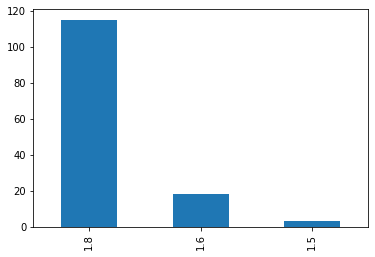

In [32]:
df.resolution.map(lambda x: round(x[0]/x[1], 1)).value_counts().plot(kind="bar")

In [33]:
def set_iteration(row):
    if row.interaction_type == "iteration-started" or row.interaction_type == "iteration-ended":
        row['iteration'] = json.loads(row.data)['iteration']
    else:
        row['iteration'] = None
    return row

def set_result_layout(row):
    if row.interaction_type == "iteration-started":
        row['result_layout'] = json.loads(row.data)['result_layout']
    else:
        row['result_layout'] = None
    return row

#'algorithm_assignment': {'0': {'algorithm': 'relevance_based',
#   'name': 'gamma',
#   'order': 1},
#  '1': {'algorithm': 'weighted_average', 'name': 'delta', 'order': 0}},

def set_mapping(row):
    if row.interaction_type == 'iteration-started':
        dat = json.loads(row.data)['algorithm_assignment'].values()
        for mapping in dat:
            row[mapping['name'].upper()] = mapping['order']
    else:
        row['GAMMA'] = None
        row['DELTA'] = None
    return row

In [124]:
d = d.apply(set_iteration, axis=1).apply(set_result_layout, axis=1).apply(set_mapping, axis=1)

In [125]:
d['iteration'] = d.groupby(['participation'], sort=False)['iteration'].apply(lambda x: x.ffill())

In [126]:
d['iteration'] = d.groupby(['participation'], sort=False)['iteration'].apply(lambda x: x.ffill())
d['result_layout'] = d.groupby(['participation'], sort=False)['result_layout'].apply(lambda x: x.ffill())
d['GAMMA'] = d.groupby(['participation'], sort=False)['GAMMA'].apply(lambda x: x.ffill())
d['DELTA'] = d.groupby(['participation'], sort=False)['DELTA'].apply(lambda x: x.ffill())

In [127]:
d = d[d.iteration.notna()]

In [38]:
def set_dim(x):
    data = json.loads(x.data)
    if not 'screen_sizes' in data:
        x['innerWidth'] = None
        x['innerHeight'] = None
        x['scrollWidth'] = None
        x['scrollHeight'] = None
        x['viewport'] = None
    else:
        x['viewport'] = data['viewport']
        data = data['screen_sizes']
        x['innerWidth'] = data['window.innerWidth']
        x['innerHeight'] = data['window.innerHeight']
        x['scrollWidth'] = data['document.body.scrollWidth']
        x['scrollHeight'] = data['document.body.scrollHeight']
        
    return x

def get_abs_coord(selected_item_viewport, viewport):
    return {
        "left": selected_item_viewport['left'] - viewport['left'],
        "top": selected_item_viewport['top'] - viewport['top']
    };


In [128]:
d = d.apply(set_dim, axis=1)
d['innerWidth'] = d.groupby(['participation'], sort=False)['innerWidth'].apply(lambda x: x.ffill())
d['innerHeight'] = d.groupby(['participation'], sort=False)['innerHeight'].apply(lambda x: x.ffill())
d['scrollWidth'] = d.groupby(['participation'], sort=False)['scrollWidth'].apply(lambda x: x.ffill())
d['scrollHeight'] = d.groupby(['participation'], sort=False)['scrollHeight'].apply(lambda x: x.ffill())
d['viewport'] = d.groupby(['participation'], sort=False)['viewport'].apply(lambda x: x.ffill())

In [40]:
d

,DELTA,GAMMA,data,innerHeight,innerWidth,interaction_type,iteration,layout_high_level,participation,result_layout,scrollHeight,scrollWidth,time,variant,viewport
id,,,,,,,,,,,,,,,
3263,0.0,1.0,"{""iteration"": 1, ""weights"": [0.333333333333333...",NaN,NaN,iteration-started,1.0,rows,36,row-single-scrollable,NaN,NaN,2023-01-15 23:15:47.966024,-1,None
3264,0.0,1.0,"{""page"": ""compare_algorithms"", ""context"": {""ur...",NaN,NaN,loaded-page,1.0,rows,36,row-single-scrollable,NaN,NaN,2023-01-15 23:15:48.307382,-1,None
3265,0.0,1.0,"{""viewport"": {""left"": 0, ""top"": 0, ""width"": 25...",1329.0,2560.0,changed-viewport,1.0,rows,36,row-single-scrollable,1104.0,2560.0,2023-01-15 23:15:48.781034,-1,"{'left': 0, 'top': 0, 'width': 2560, 'height':..."
3266,0.0,1.0,"{""viewport"": {""left"": 0, ""top"": 0, ""width"": 25...",1329.0,2560.0,changed-viewport,1.0,rows,36,row-single-scrollable,1104.0,2560.0,2023-01-15 23:15:51.597827,-1,"{'left': 0, 'top': 0, 'width': 2560, 'height':..."
3267,0.0,1.0,"{""viewport"": {""left"": 0, ""top"": 0, ""width"": 25...",1329.0,2560.0,changed-viewport,1.0,rows,36,row-single-scrollable,1104.0,2560.0,2023-01-15 23:15:53.367864,-1,"{'left': 0, 'top': 0, 'width': 2560, 'height':..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47797,1.0,0.0,"{""iteration"": 8, ""selected"": [[1231, 1184, 792...",568.0,1266.0,iteration-ended,8.0,cols,261,max-columns,1357.0,1249.0,2023-02-05 18:47:31.911054,-1,"{'left': 0, 'top': -436, 'width': 1249.3333740..."
47798,1.0,0.0,"{""iteration"": 8}",568.0,1266.0,study-ended,8.0,cols,261,max-columns,1357.0,1249.0,2023-02-05 18:47:31.915892,-1,"{'left': 0, 'top': -436, 'width': 1249.3333740..."
47799,1.0,0.0,"{""id"": """", ""text"": ""Ukončit průzkum"", ""name"": ...",568.0,1266.0,on-input,8.0,cols,261,max-columns,1357.0,1249.0,2023-02-05 18:47:31.930910,-1,"{'left': 0, 'top': -436, 'width': 1249.3333740..."


In [41]:
def set_items_positions(x):
    if x.interaction_type == 'changed-viewport':
        extra = json.loads(x.data)['context']['extra']
        if 'items' in extra:
            items = extra['items']
            x['item_positions'] = {
                item['id']: item['viewport']
                for item in items
            }
            x['item_abs_positions'] = {
                item['id']: get_abs_coord(item['viewport'], x['viewport'])
                for item in items
            }
        else:
            x['item_positions'] = None
            x['item_abs_positions'] = None
    else:
        x['item_positions'] = None
        x['item_abs_positions'] = None
    return x

In [42]:
d

,DELTA,GAMMA,data,innerHeight,innerWidth,interaction_type,iteration,layout_high_level,participation,result_layout,scrollHeight,scrollWidth,time,variant,viewport
id,,,,,,,,,,,,,,,
3263,0.0,1.0,"{""iteration"": 1, ""weights"": [0.333333333333333...",NaN,NaN,iteration-started,1.0,rows,36,row-single-scrollable,NaN,NaN,2023-01-15 23:15:47.966024,-1,None
3264,0.0,1.0,"{""page"": ""compare_algorithms"", ""context"": {""ur...",NaN,NaN,loaded-page,1.0,rows,36,row-single-scrollable,NaN,NaN,2023-01-15 23:15:48.307382,-1,None
3265,0.0,1.0,"{""viewport"": {""left"": 0, ""top"": 0, ""width"": 25...",1329.0,2560.0,changed-viewport,1.0,rows,36,row-single-scrollable,1104.0,2560.0,2023-01-15 23:15:48.781034,-1,"{'left': 0, 'top': 0, 'width': 2560, 'height':..."
3266,0.0,1.0,"{""viewport"": {""left"": 0, ""top"": 0, ""width"": 25...",1329.0,2560.0,changed-viewport,1.0,rows,36,row-single-scrollable,1104.0,2560.0,2023-01-15 23:15:51.597827,-1,"{'left': 0, 'top': 0, 'width': 2560, 'height':..."
3267,0.0,1.0,"{""viewport"": {""left"": 0, ""top"": 0, ""width"": 25...",1329.0,2560.0,changed-viewport,1.0,rows,36,row-single-scrollable,1104.0,2560.0,2023-01-15 23:15:53.367864,-1,"{'left': 0, 'top': 0, 'width': 2560, 'height':..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47797,1.0,0.0,"{""iteration"": 8, ""selected"": [[1231, 1184, 792...",568.0,1266.0,iteration-ended,8.0,cols,261,max-columns,1357.0,1249.0,2023-02-05 18:47:31.911054,-1,"{'left': 0, 'top': -436, 'width': 1249.3333740..."
47798,1.0,0.0,"{""iteration"": 8}",568.0,1266.0,study-ended,8.0,cols,261,max-columns,1357.0,1249.0,2023-02-05 18:47:31.915892,-1,"{'left': 0, 'top': -436, 'width': 1249.3333740..."
47799,1.0,0.0,"{""id"": """", ""text"": ""Ukončit průzkum"", ""name"": ...",568.0,1266.0,on-input,8.0,cols,261,max-columns,1357.0,1249.0,2023-02-05 18:47:31.930910,-1,"{'left': 0, 'top': -436, 'width': 1249.3333740..."


In [129]:
d = d.apply(set_items_positions, axis=1).groupby(['participation'], sort=False).apply(lambda x: x.ffill())

In [45]:
def set_variant(x):
    if x.interaction_type == 'selected-item' or x.interaction_type == 'deselected-item':
        dat = json.loads(x.data)[x.interaction_type.replace('-', '_')]
        if 'variant' in dat:
            x['variant'] = dat['variant']
        else:
            x['variant'] = None
    else:
        x['variant'] = None
    return x

def set_selected_item(x):
    it = json.loads(x.data)
    if 'selected_item' not in it:
        if "deselected_item" in it:
            it = it['deselected_item']
        else:
            x['selected_item'] = None
            x['selected_item_coord'] = None
            return x
    else:
        it = it['selected_item']
    
    algo = 'GAMMA'
    assert x.variant == it['variant']
    if x.variant == x.DELTA:
        algo = 'DELTA'
    it_name = f"{algo}_{it['movie_idx']}"
    if it_name not in x['item_positions']:
        x['selected_item'] = None
        x['selected_item_coord'] = None
        x['selected_item_abs_coord'] = None
    else:
        x['selected_item'] = it_name
        x['selected_item_coord'] = x['item_positions'][x['selected_item']]
        x['selected_item_abs_coord'] = get_abs_coord(x['selected_item_coord'], x['viewport'])
    return x

In [47]:
def get_grid_positions_impl(x, exp_x_positions, exp_y_positions):
    assert bool(exp_x_positions) == bool(exp_y_positions)
    
    x_positions = set([y['left'] for y in x.values()])
    if exp_x_positions and len(x_positions) != exp_x_positions:
        return None # single columns should have 2 grid positions
    x_positions = sorted(list(x_positions))
    
    y_positions = set([y['top'] for y in x.values()])
    if exp_y_positions and len(y_positions) != exp_y_positions:
        return None # single columns should have 10 grid positions in vertical direction
    y_positions = sorted(list(y_positions))
    
    return {
        item_id: {
            'x': x_positions.index(vals['left']),
            'y': y_positions.index(vals['top'])
        } for item_id, vals in x.items()
    }

map_1d_to_2d = [
    (0, 0),
    (1, 0),
    (2, 0),
    (3, 0),
    (0, 1),
    (1, 1),
    (2, 1),
    (3, 1),
    (1, 2),
    (2, 2)
]

def get_grid_positions(x, result_layout):
    if result_layout == 'columns':
        return get_grid_positions_impl(x, 4, 5)
    elif result_layout == 'rows':
        return get_grid_positions_impl(x, 5, 4)
    elif result_layout == 'row-single':
        return get_grid_positions_impl(x, 10, 2)
    elif result_layout == 'column-single':
        return get_grid_positions_impl(x, 2, 10)
    elif result_layout == 'row-single-scrollable':
        # Special calculation, because there can be up to 20 different x coordinates (different scroll)
        #return get_grid_positions_impl(x, 10, 2)
        result = dict()
        for item_id, item_pos in x.items():
            n_items_above = 0
            n_items_above_2 = 0
            n_items_before = 0
            for item2_id, item2_pos in x.items():
                if item_id != item2_id and item2_id[:len("GAMMA")] == item_id[:len("DELTA")]:
                    if item2_pos['top'] < item_pos['top']:
                        n_items_above += 1
                    elif item2_pos['top'] == item_pos['top'] and item2_pos['left'] < item_pos['left']:
                        n_items_before += 1
                if item_id != item2_id and item2_pos['top'] < item_pos['top']:
                    n_items_above_2 += 1
            result[item_id] = {
                "x": n_items_before,
                "y": n_items_above if n_items_above == n_items_above_2 else n_items_above + 1
            }
        return result
    elif result_layout == 'max-columns':
        # We do a special calculation here
        # first we map it to 1D index 0, ..., K-1 and then map it back to 
        # 2D index in layout corresponding to full HD (4, 4, 2) items
        result = dict()
        for item_id, item_pos in x.items():
            n_items_above = 0
            n_items_before = 0
            n_items_before_2 = 0
            for item2_id, item2_pos in x.items():
                if item_id != item2_id and item2_id[:len("GAMMA")] == item_id[:len("DELTA")]:
                    if item2_pos['top'] < item_pos['top']:
                        n_items_above += 1
                    elif item2_pos['top'] == item_pos['top'] and item2_pos['left'] < item_pos['left']:
                        n_items_before += 1
                
                if item_id != item2_id and item2_pos['top'] == item_pos['top'] and item2_pos['left'] < item_pos['left']:
                    n_items_before_2 += 1
            idx = n_items_above + n_items_before # This is 1D index of the item
            x_coord, y_coord = map_1d_to_2d[idx]
            result[item_id] = {
                "x": x_coord if n_items_before == n_items_before_2 else x_coord + 4,
                "y": y_coord
            }
        return result
        #return get_grid_positions_impl(x, None, None) # Resolution dependent

def set_selected_item_grid_coord(row):
    row['selected_item_grid_coord'] = row['grid_coords'][row.selected_item]
    return row

In [50]:
from functools import partial

def prep_heatmap_df(df_it, result_layout, include_selected = True, include_deselected = False):
    assert include_selected or include_deselected, "At least one of them must be included to show anything"
    df_filtered = df_it[df_it["result_layout"] == result_layout]
    if include_selected and include_deselected:
        df_filtered = df_filtered[((df_filtered["interaction_type"] == "selected-item")|(df_filtered["interaction_type"] == "deselected-item"))]
    elif include_selected:
        df_filtered = df_filtered[df_filtered["interaction_type"] == "selected-item"]
    else:
        # Include selected
        df_filtered = df_filtered[df_filtered["interaction_type"] == "deselected-item"]
    # TODO
    df_filtered = df_filtered.apply(set_variant, axis=1)
    df_filtered = df_filtered[df_filtered.variant.notna()]
    
    df_filtered.GAMMA = df_filtered.GAMMA.astype(int)
    df_filtered.DELTA = df_filtered.DELTA.astype(int)
    df_filtered.iteration = df_filtered.iteration.astype(int)
    df_filtered.innerWidth = df_filtered.innerWidth.astype(int)
    df_filtered.innerHeight = df_filtered.innerHeight.astype(int)
    df_filtered.scrollWidth = df_filtered.scrollWidth.astype(int)
    df_filtered.scrollHeight = df_filtered.scrollHeight.astype(int)
    
    df_filtered = df_filtered.apply(set_selected_item, axis=1)
    df_filtered = df_filtered[df_filtered.selected_item.notna()]
    
    df_filtered.loc[:, 'grid_coords'] = df_filtered.item_positions.map(partial(get_grid_positions, result_layout=result_layout))
    df_filtered = df_filtered[df_filtered.grid_coords.notna()]
    
    df_filtered = df_filtered.apply(set_selected_item_grid_coord, axis=1)
    
    return df_filtered

In [130]:
d = d.dropna()

In [54]:
# Mapping grid coordinates to absolute (pixel) coordinates before drawing colormap/heatmap
x_to_abs_left = {
    'columns': {
        0: 297,
        1: 502,
        2: 1243,
        3: 1448
    },
    'rows': {
        0: 391,
        1: 621,
        2: 851,
        3: 1081,
        4: 1311
    },
    'column-single': {
        0: 399,
        1: 1345
    },
    'row-single': {
        0: 34,
        1: 222,
        2: 410,
        3: 598,
        4: 786,
        5: 975,
        6: 1163,
        7: 1351,
        8: 1539,
        9: 1727
    },
    'max-columns': {
        0: 42,
        1: 272,
        2: 502,
        3: 732,
        4: 988,
        5: 1218,
        6: 1448,
        7: 1678,
    },
    #'row-single-scrollable': {
    #    0: 500,
    #    1: 718,
    #    2: 937,
    #    3: 1156,
    #    4: 1375,
    #    5: 1593,
    #    6: 1812,
    #    7: 2031,
    #    8: 2249,
    #    9: 2468
    #}
    'row-single-scrollable': { # align with row-single
        0: 34,
        1: 222,
        2: 410,
        3: 598,
        4: 786,
        5: 975,
        6: 1163,
        7: 1351,
        8: 1539,
        9: 1727
    },
}

y_to_abs_top = {
    'columns': {
        0: 196,
        1: 459,
        2: 722,
        3: 985,
        4: 1248
    },
    'rows': {
        0: 192,
        1: 492,
        2: 909,
        3: 1209
    },
    'column-single': {
        0: 196,
        1: 459,
        2: 722,
        3: 985,
        4: 1248,
        5: 1511,
        6: 1744,
        7: 2037,
        8: 2300,
        9: 2563
    },
    'row-single': {
        0: 192,
        1: 547
    },
    'max-columns': {
        0: 196,
        1: 492,
        2: 788
    },
    'row-single-scrollable': {
        0: 192,
        1: 547 # align with row-single 595
    }
}

In [55]:
# Approximation from grid coordinates (maps to full-HD equivalent)
def set_coords(row):
    row['x_coords'] = x_to_abs_left[row.result_layout][row.selected_item_grid_coord['x']]
    row['y_coords'] = y_to_abs_top[row.result_layout][row.selected_item_grid_coord['y']]
    return row

    
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

def plot_selection_coords(coords, n_norm = None):
    coords = coords.groupby(['x_coords', 'y_coords']).agg(n=("y_coords", "count"))
    print(coords)
    if n_norm:
        print(coords)
        coords = coords / n_norm
        print(coords)
    ax = sns.kdeplot(data = coords, weights="n", x="x_coords", y="y_coords", fill=True, thresh=0.1, levels=100, cmap="turbo")
    #sns.kdeplot(data = coords, weights="n", x="x_coords", y="y_coords", clip=(0, 1500), thresh=0.1, fill=True, n_levels=100, cmap="mako")
    plt.gca().invert_yaxis()
    plt.show()

In [56]:
import scipy.ndimage.filters as filters


def plot(data, title, save_path):
    fig = plt.figure(figsize=(18, 18))
    
    mycmap = plt.cm.jet
    mycmap._init()
    N = 255
    mycmap._lut[:,-1] = np.linspace(0, 1.0, N+4)
    
    plt.imshow(data, cmap=mycmap)
    #plt.colorbar()
    plt.title(title)
    plt.axis('off')
    plt.savefig(save_path, bbox_inches='tight')

In [57]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np



def plot_heatmap_for_layout(result_layout, w=1750, h=1500, x_shift=0):
    data = plot_heatmap(df_filled, result_layout, True, False).apply(set_coords, axis=1)[['x_coords', 'y_coords']]
    matrix = np.zeros((w, h), dtype=np.float32)
    cnt = data.groupby(['x_coords', 'y_coords']).aggregate(n=("y_coords", "count"))
    matrix[cnt.index.get_level_values(0).values + x_shift, cnt.index.get_level_values(1).values] = cnt['n']
    idx = matrix <= 0
    data = filters.gaussian_filter(matrix.T * 10000, sigma=50)
    #data[data <= 0.45] = np.nan

    plot(data, f'Selections {result_layout}', f'selections_{result_layout}.jpg')

In [59]:
maxs = []
mins = []
for result_layout in d.result_layout.unique():
    r = prep_heatmap_df(d, result_layout, True, False).apply(set_coords, axis=1)[['x_coords', 'y_coords']].groupby(['x_coords', 'y_coords']).aggregate(n=("y_coords", "count")).n
    ps = r / r.sum()
    maxs.append(ps.max())
    mins.append(ps.min())
tot_max = max(maxs)
tot_min = min(mins)

In [60]:
tot_min, tot_max

(0.030563514804202482, 0.07067812798471824)

C:\Users\PD\AppData\Local\Temp/ipykernel_24288/3435759121.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


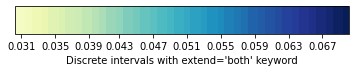

In [63]:
import matplotlib as mpl
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)
cmap = plt.cm.YlGnBu
minval = 0.05
maxval = 1.0
cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, 100)))
bounds = np.linspace(tot_min, tot_max, 100)
bounds = np.round(bounds, 3)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal',
             label="Discrete intervals with extend='both' keyword")
fig.show()
custom_cmap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

In [65]:
import matplotlib.patches as patches
def draw_color_map(df_filled, result_layout, w=1950, h=1500, img_w = 200, img_h = 200, glob_min = None, glob_max = None, cb=True, special="", custom_cmap=None, norm=None):
    fig, ax = plt.subplots(figsize=(12,12))
    ax.set_aspect("equal")
    ax.set_xlim((0, w))
    ax.set_ylim((0, h))

    qt = prep_heatmap_df(df_filled, result_layout, True, False).apply(set_coords, axis=1)[['x_coords', 'y_coords']].groupby(['x_coords', 'y_coords']).aggregate(n=("y_coords", "count"))
    qt.n = qt.n / qt.n.sum()
    #if glob_min is None:
    #    glob_min = qt.min()
    #if glob_max is None:
    #    glob_max = qt.max()
    #qt = (qt - glob_min) / (glob_max - glob_min)
    #qt = qt * 0.9 + 0.1
    
    for idx, row in qt.iterrows():
        rect = patches.Rectangle(idx, img_w, img_h, linewidth=1, facecolor=custom_cmap.get_cmap()(norm(row.n)))
        ax.add_patch(rect)


    plt.gca().invert_yaxis()
    if cb:
        fig.colorbar(custom_cmap, ax=ax)
    #plt.title(f"Selections {result_layout}")
    plt.axis('off')
    plt.savefig(f"selections_colormap_{result_layout}_YlGnBu_cb={cb}_{special}.jpg", bbox_inches='tight')
    plt.show()

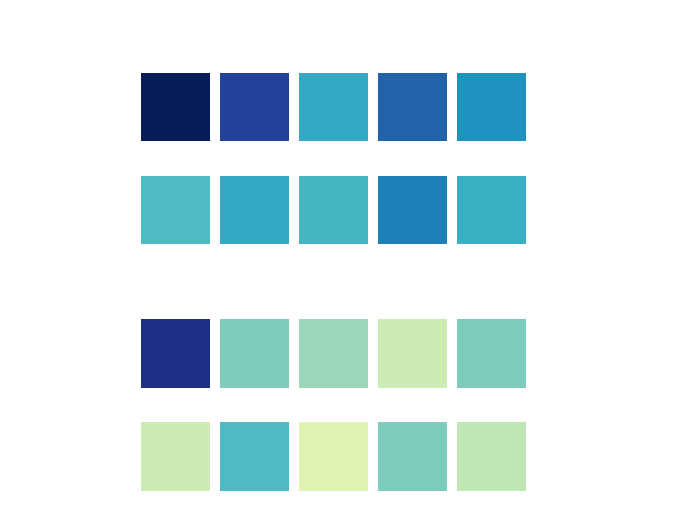

In [68]:
draw_color_map(d, "rows", cb=False, glob_min = tot_min, glob_max = tot_max, custom_cmap=custom_cmap, norm=norm)

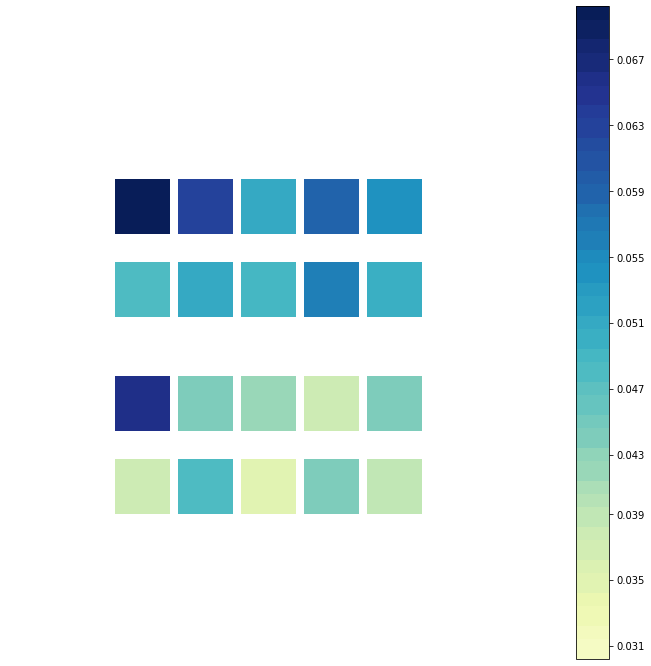

In [69]:
draw_color_map(d, "rows", cb=True, glob_min = tot_min, glob_max = tot_max, custom_cmap=custom_cmap, norm=norm)

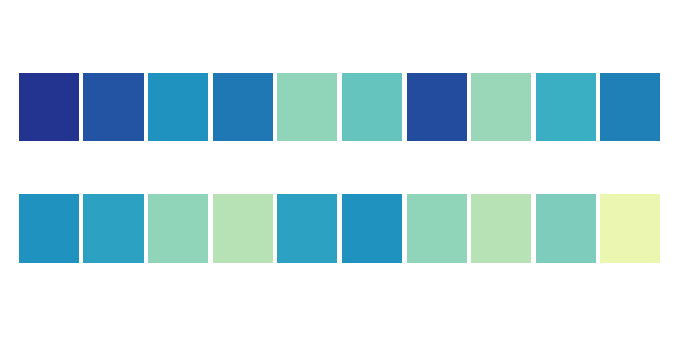

In [71]:
draw_color_map(d, "row-single-scrollable", img_w=175, h = 950, cb=False, glob_min = tot_min, glob_max = tot_max, custom_cmap=custom_cmap, norm=norm)

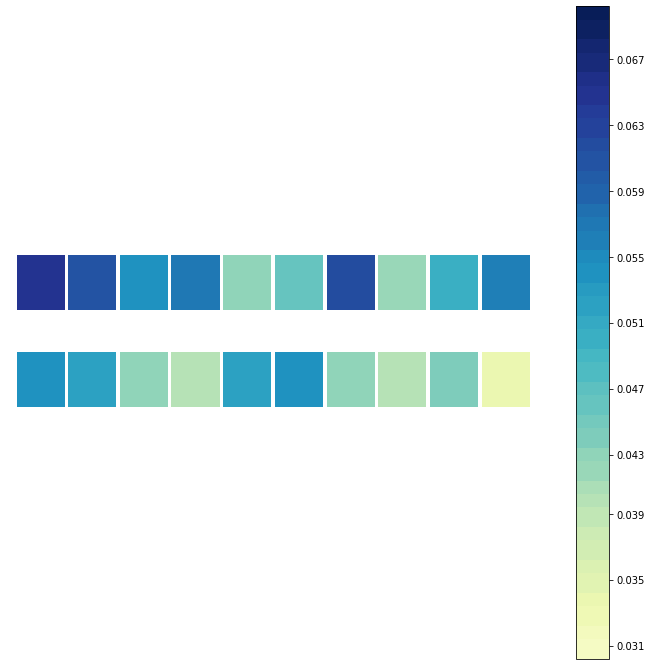

In [72]:
draw_color_map(d, "row-single-scrollable", img_w=175, h = 950, cb=True, glob_min = tot_min, glob_max = tot_max, custom_cmap=custom_cmap, norm=norm)

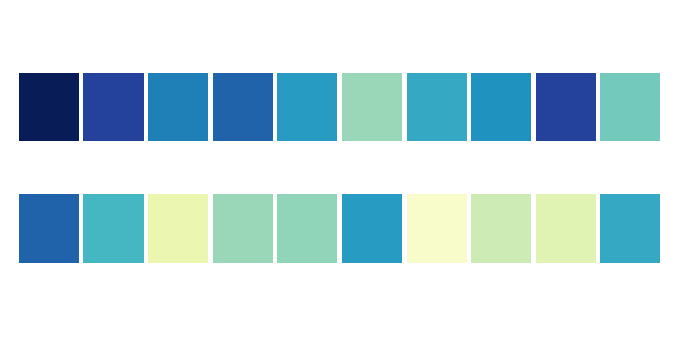

In [73]:
draw_color_map(d, "row-single", img_w=175, h = 950, cb = False, glob_min = tot_min, glob_max = tot_max, custom_cmap=custom_cmap, norm=norm)

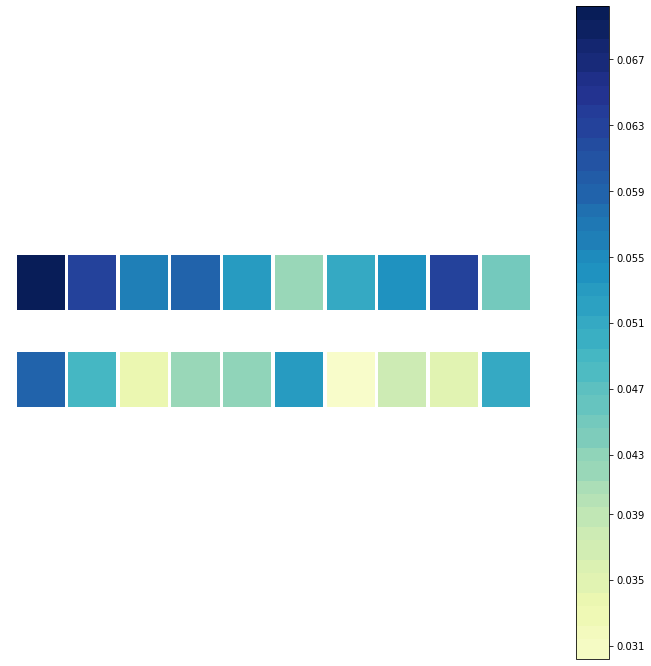

In [74]:
draw_color_map(d, "row-single", img_w=175, h = 950, cb = True, glob_min = tot_min, glob_max = tot_max, custom_cmap=custom_cmap, norm=norm)

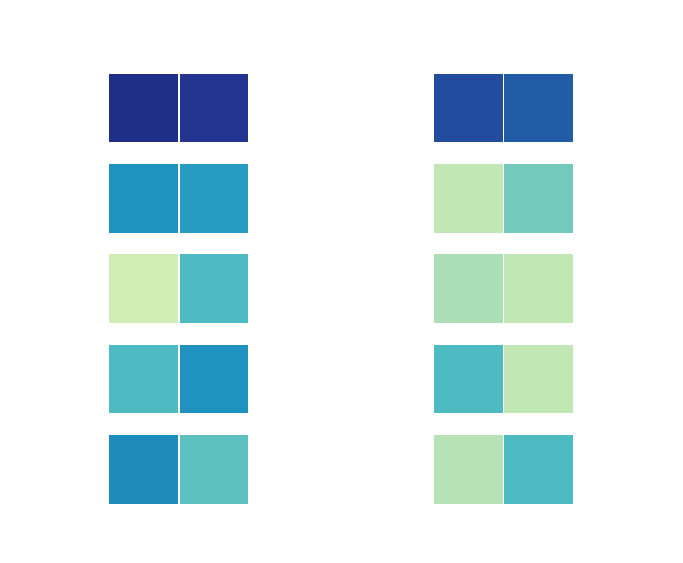

In [75]:
draw_color_map(d, "columns", h = 1600, cb=False, glob_min = tot_min, glob_max = tot_max, custom_cmap=custom_cmap, norm=norm)

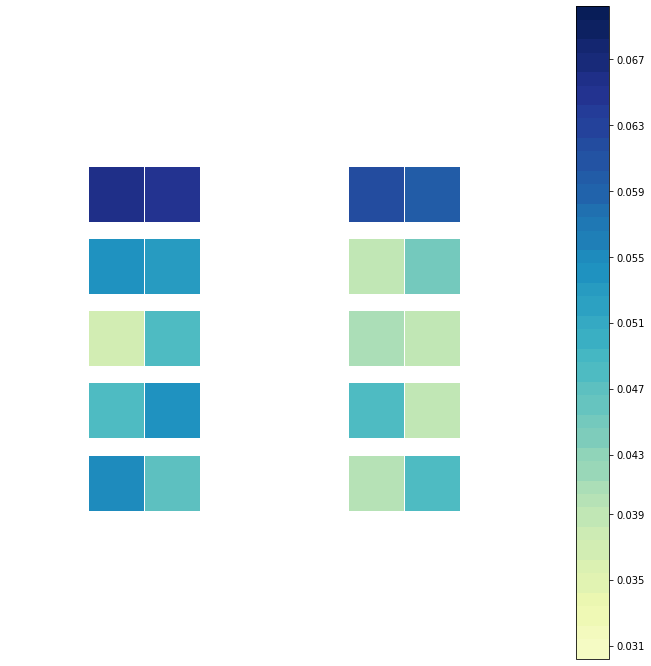

In [76]:
draw_color_map(d, "columns", h = 1600, cb=True, glob_min = tot_min, glob_max = tot_max, custom_cmap=custom_cmap, norm=norm)

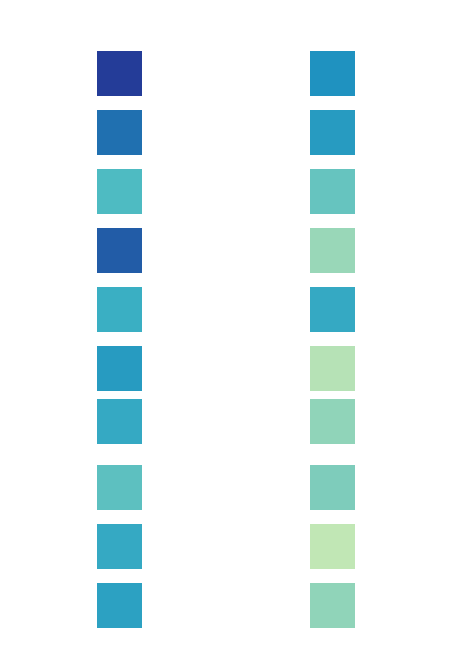

In [77]:
draw_color_map(d, "column-single", w=1950, h=2900, img_w = 200, img_h = 200, cb=False, glob_min = tot_min, glob_max = tot_max, custom_cmap=custom_cmap, norm=norm)

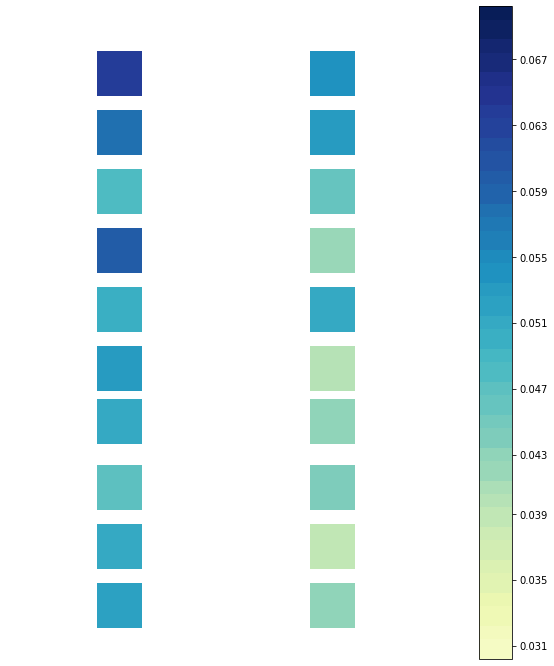

In [78]:
draw_color_map(d, "column-single", w=1950, h=2900, img_w = 200, img_h = 200, cb=True, glob_min = tot_min, glob_max = tot_max, custom_cmap=custom_cmap, norm=norm)

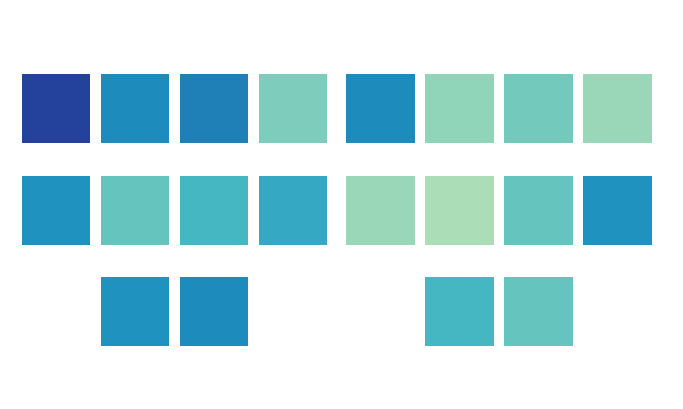

In [79]:
draw_color_map(d, "max-columns", h = 1150, cb=False, glob_min = tot_min, glob_max = tot_max, custom_cmap=custom_cmap, norm=norm)

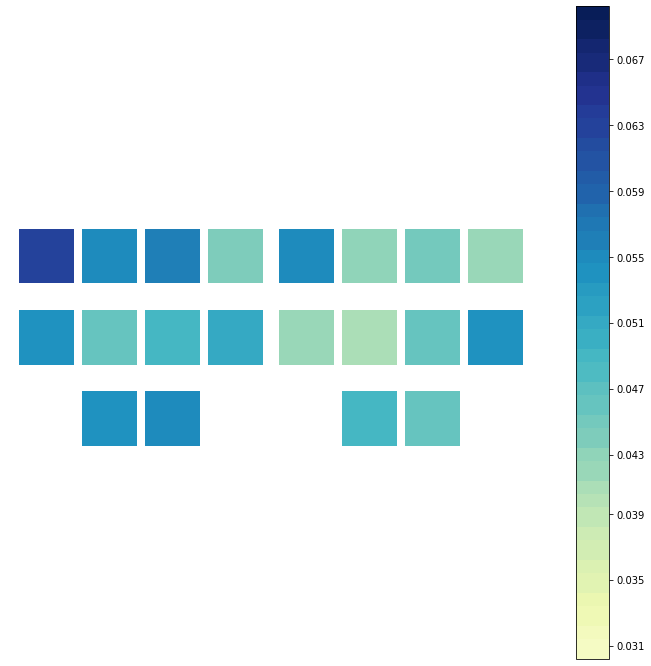

In [80]:
draw_color_map(d, "max-columns", h = 1150, cb=True, glob_min = tot_min, glob_max = tot_max, custom_cmap=custom_cmap, norm=norm)

In [81]:
def set_variant_name(row):
    if row["variant"] != -1:
        if row["GAMMA"] == row["variant"]:
            row["variant_name"] = "GAMMA"
        elif row["DELTA"] == row["variant"]:
            row["variant_name"] = "DELTA"
        else:
            row["variant_name"] = None
    else:
        row["variant_name"] = None
    return row
df2 = df2.apply(set_variant_name, axis=1)

NameError: name 'df2' is not defined

# Items in both recommendations

In [131]:
d = d[d.interaction_type == "selected-item"]
d = d.apply(set_variant, axis=1)
d = d[d.variant.notna()]   
d = d.apply(set_selected_item, axis=1)
d = d[d.selected_item.notna()]


In [93]:
def selected_in_both_algorithms(row):
    item_id = row["selected_item"].split("_")[1]
    occurrences = 0
    for item in row["item_positions"].keys():
        if not item:
            #print("Weird")
            continue
        if item_id == item.split("_")[1]:
            occurrences += 1
    assert occurrences >= 1
    assert occurrences <= 2
    return occurrences == 2

In [ ]:
df = d.copy()

In [94]:
df.loc[:, "selected_in_both"] = df.apply(selected_in_both_algorithms , axis=1)

In [95]:
df[df.selected_in_both].groupby(["result_layout"]).agg(n=("result_layout", "count"))

,n
result_layout,
column-single,179
columns,148
max-columns,143
row-single,169
row-single-scrollable,134
rows,186


In [96]:
df = df[df.selected_in_both]

In [101]:
def prep_double_data(df_filled, result_layout):
    dt = prep_heatmap_df(df_filled, result_layout)
    dt.loc[:, "selected_in_both"] = dt.apply(selected_in_both_algorithms , axis=1)
    dt = dt[dt.selected_in_both]
    dt = dt.dropna()
    return dt



In [102]:
maxs = []
mins = []
for result_layout in df.result_layout.unique():
    r = prep_double_data(df, result_layout).apply(set_coords, axis=1)[['x_coords', 'y_coords']].groupby(['x_coords', 'y_coords']).aggregate(n=("y_coords", "count")).n
    ps = r / r.sum()
    maxs.append(ps.max())
    mins.append(ps.min())
tot_max = max(maxs)
tot_min = 0.0 # There are actually some 0 that are then missing the list so hardcode it here min(mins)

In [103]:
def plot_double_recommendation(df_filled, result_layout, special, **kwargs):
    
    import matplotlib as mpl
    #fig, ax = plt.subplots(figsize=(6, 1))
    #fig.subplots_adjust(bottom=0.5)
    cmap = plt.cm.YlGnBu
    minval = 0.05
    maxval = 1.0
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
            'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
            cmap(np.linspace(minval, maxval, 100)))
    bounds = np.linspace(tot_min, tot_max, 100)
    bounds = np.round(bounds, 3)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    #fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    #             cax=ax, orientation='horizontal',
    #             label="Discrete intervals with extend='both' keyword")
    #fig.show()
    custom_cmap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    
    dt = prep_double_data(df_filled, result_layout)
    draw_color_map(dt, result_layout, special=special, custom_cmap=custom_cmap, norm=norm, **kwargs)

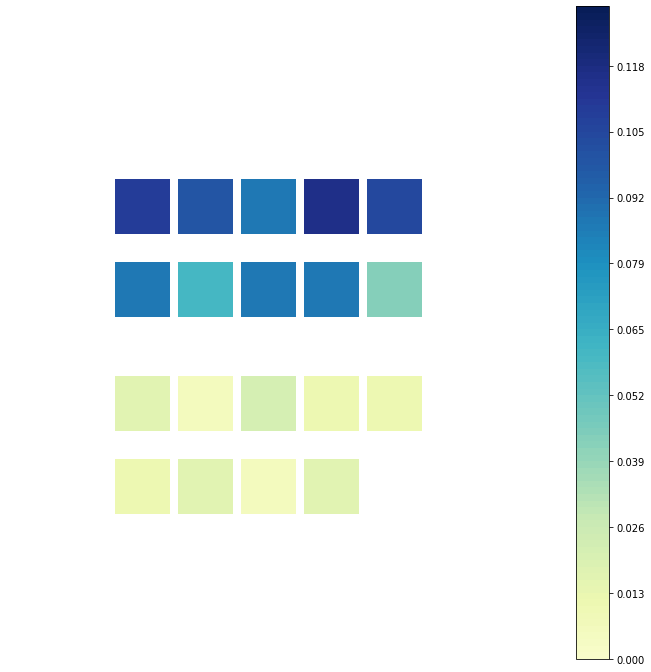

In [104]:
plot_double_recommendation(df, "rows", "both_algo", cb=True)

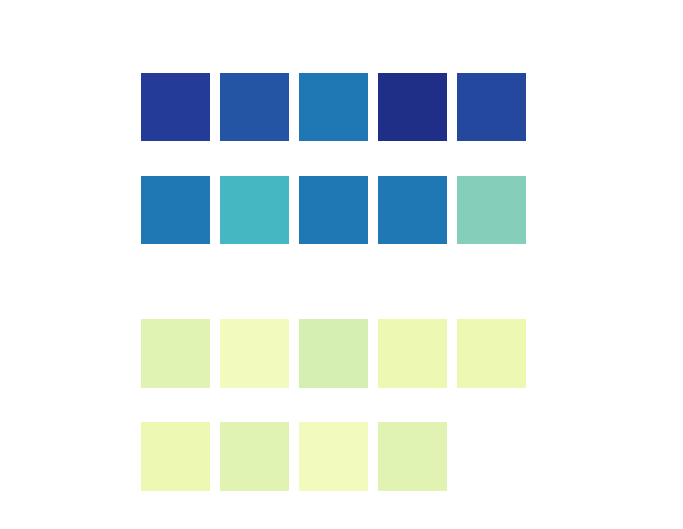

In [106]:
plot_double_recommendation(df, "rows", "both_algo", cb=False)

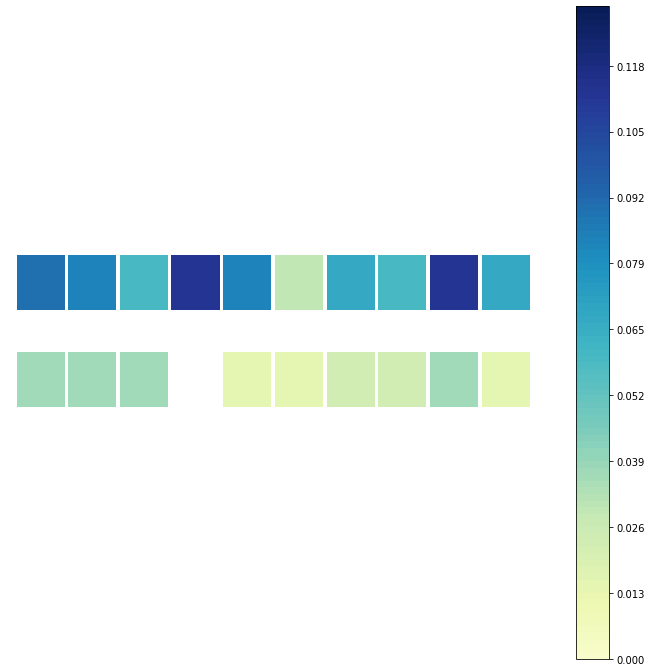

In [107]:
plot_double_recommendation(df, "row-single-scrollable", "both_algo", img_w=175, h = 950, cb=True)

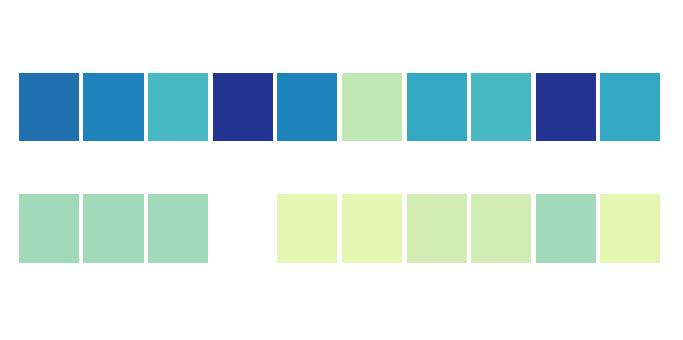

In [108]:
plot_double_recommendation(df, "row-single-scrollable", "both_algo", img_w=175, h = 950, cb=False)

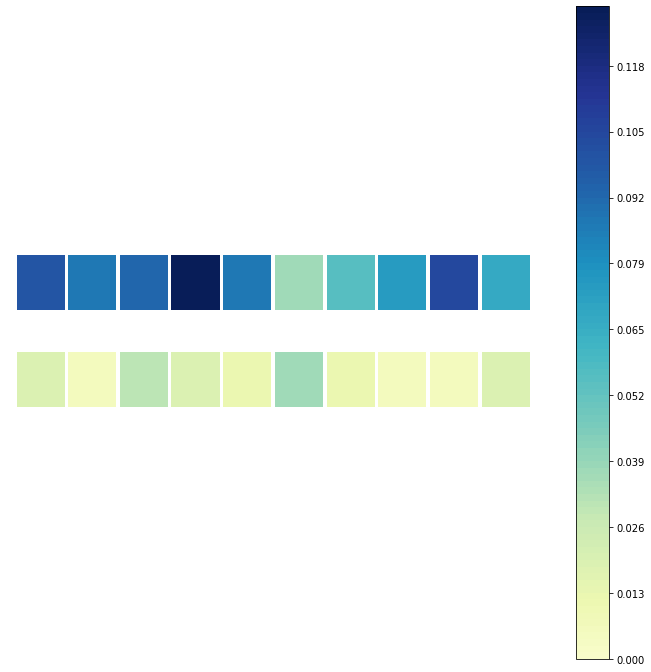

In [109]:
plot_double_recommendation(df, "row-single", "both_algo", img_w=175, h = 950, cb = True)

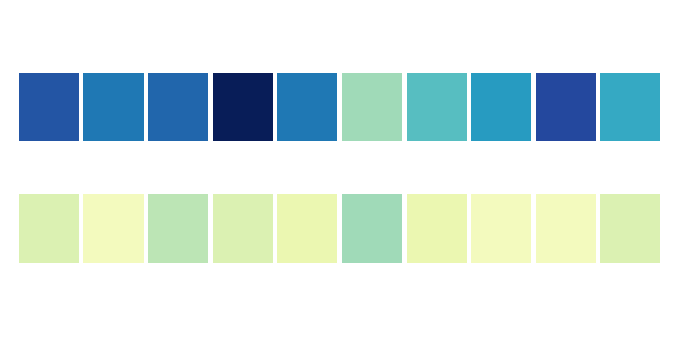

In [110]:
plot_double_recommendation(df, "row-single", "both_algo", img_w=175, h = 950, cb = False)

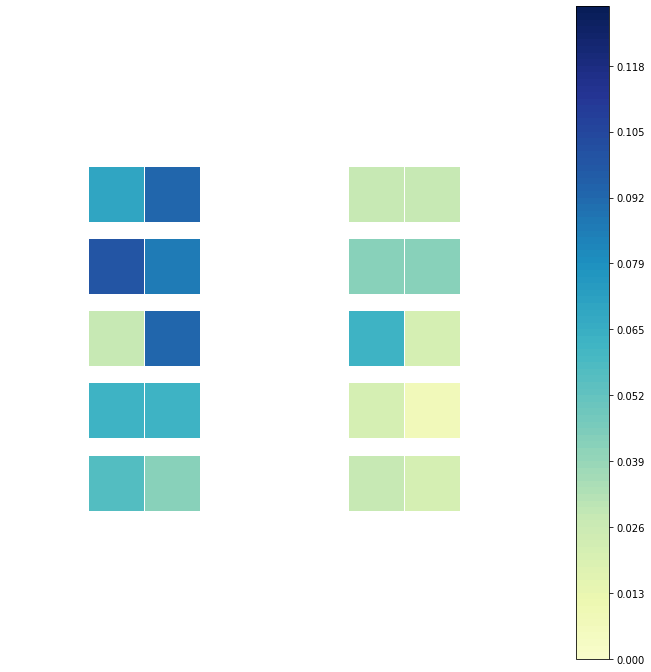

In [111]:
plot_double_recommendation(df, "columns", "both_algo", h = 1600, cb=True)

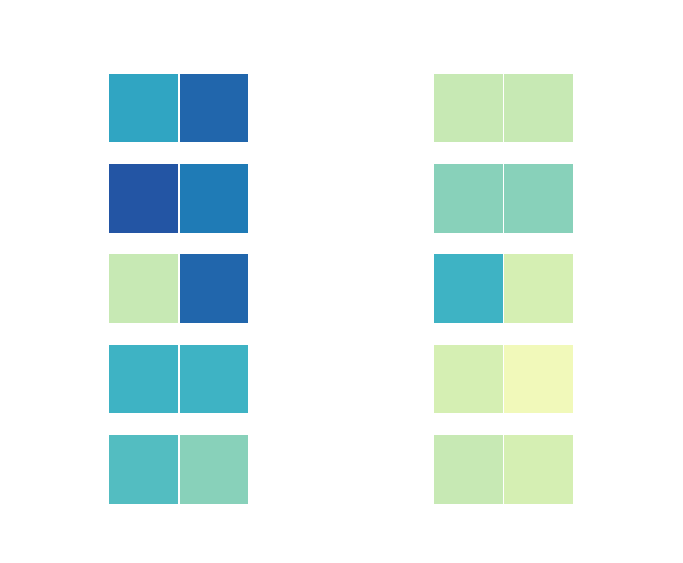

In [112]:
plot_double_recommendation(df, "columns", "both_algo", h = 1600, cb=False)

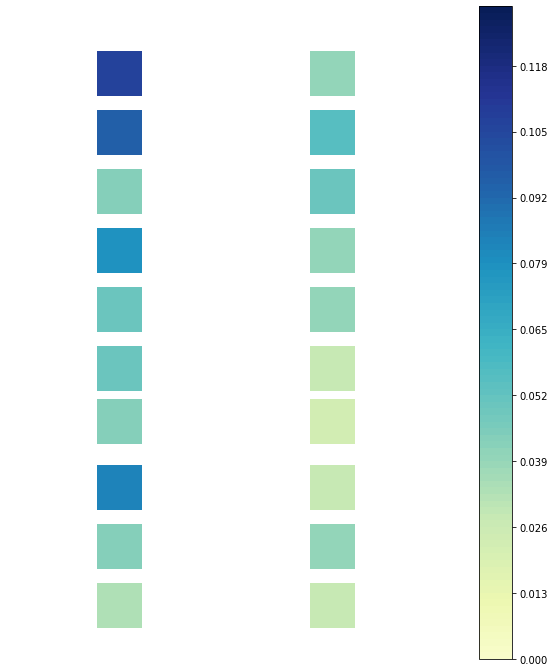

In [113]:
plot_double_recommendation(df, "column-single", "both_algo", w=1950, h=2900, img_w = 200, img_h = 200, cb=True)

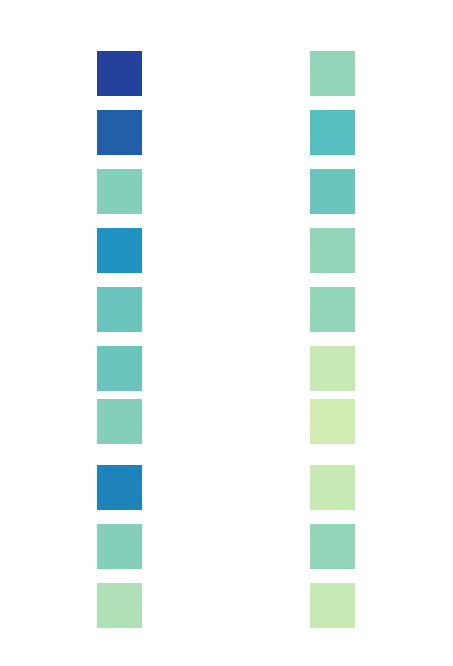

In [114]:
plot_double_recommendation(df, "column-single", "both_algo", w=1950, h=2900, img_w = 200, img_h = 200, cb=False)

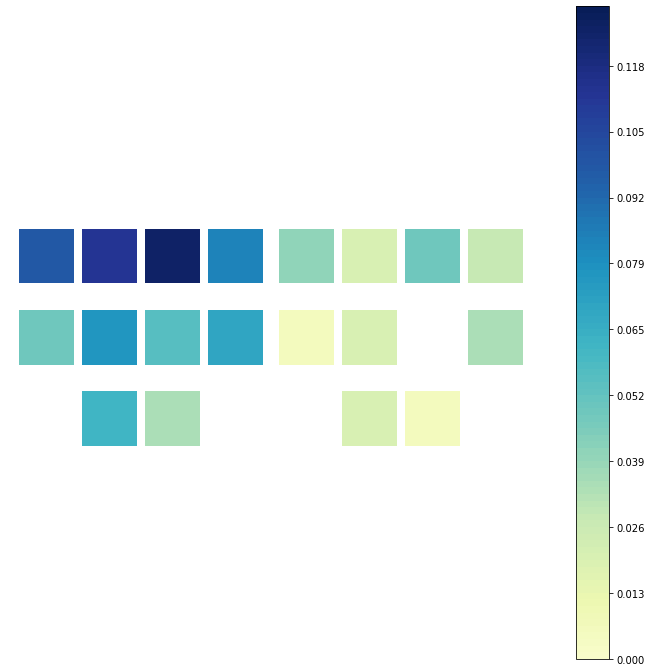

In [115]:
plot_double_recommendation(df, "max-columns", "both_algo", h = 1150, cb=True)

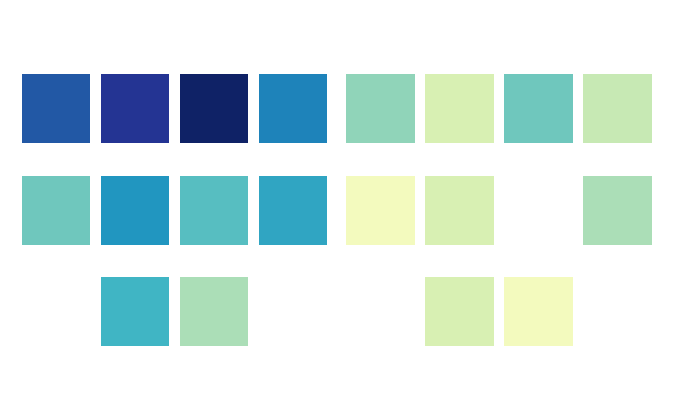

In [116]:
plot_double_recommendation(df, "max-columns", "both_algo", h = 1150, cb=False)

In [132]:
def rank_of(item_grid_coords, item):
    algo = item.split("_")[0]
    idx = 0
    for it in item_grid_coords.keys():
        if it.startswith(algo):
            if it == item:
                return idx
            idx += 1
    assert False

def add_preferred_variant_position(row):
    gamma_rank = 0
    delta_rank = 0
    idx = row.selected_item.split("_")[1]
    gamma_idx = f"GAMMA_{idx}"
    delta_idx = f"DELTA_{idx}"
    
    if row["GAMMA"] == 0:
        row["variant_0_rank"] = rank_of(row["grid_coords"], gamma_idx)
        row["variant_1_rank"] = rank_of(row["grid_coords"], delta_idx)
    elif row["DELTA"] == 0:
        row["variant_0_rank"] = rank_of(row["grid_coords"], delta_idx)
        row["variant_1_rank"] = rank_of(row["grid_coords"], gamma_idx)
    else:
        assert False
        
    if row["variant_0_rank"] < row["variant_1_rank"]:
        row["preferred_rank"] = -1 
    elif row["variant_0_rank"] == row["variant_1_rank"]:
        row["preferred_rank"] = 0
    else:
        row["preferred_rank"] = 1
        
    return row

In [133]:
# Add selection order to each selection
d.loc[:, 'selection_order'] = d.groupby(["participation","iteration"]).cumcount()+1

In [134]:
def plot_ith_selection_new(df_filled, i, result_layout, special, **kwargs):
    maxs = []
    mins = []
    
    for rl in df_filled.result_layout.unique():
        r = plot_heatmap(df_filled[df_filled.selection_order == i], rl).apply(set_coords, axis=1)[['x_coords', 'y_coords']].groupby(['x_coords', 'y_coords']).aggregate(n=("y_coords", "count")).n
        ps = r / r.sum()
        maxs.append(ps.max())
        mins.append(ps.min())
    tot_max = max(maxs)
    tot_min = min(mins) # There are actually some 0 that are then missing the list so hardcode it here min(mins)
    

    import matplotlib as mpl
    cmap = plt.cm.YlGnBu
    minval = 0.05
    maxval = 1.0
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
            'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
            cmap(np.linspace(minval, maxval, 100)))
    bounds = np.linspace(tot_min, tot_max, 100)
    bounds = np.round(bounds, 3)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    #fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    #             cax=ax, orientation='horizontal',
    #             label="Discrete intervals with extend='both' keyword")
    #fig.show()
    custom_cmap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    
    draw_color_map(df_filled[df_filled.selection_order == i], result_layout, special=special, custom_cmap=custom_cmap, norm=norm, **kwargs)

def plot_within_ith_selection_new(df_filled, i, result_layout, special, **kwargs):
    maxs = []
    mins = []
    
    for rl in df_filled.result_layout.unique():
        r = plot_heatmap(df_filled[df_filled.selection_order <= i], rl).apply(set_coords, axis=1)[['x_coords', 'y_coords']].groupby(['x_coords', 'y_coords']).aggregate(n=("y_coords", "count")).n
        ps = r / r.sum()
        maxs.append(ps.max())
        mins.append(ps.min())
    tot_max = max(maxs)
    tot_min = min(mins) # There are actually some 0 that are then missing the list so hardcode it here min(mins)
    

    import matplotlib as mpl
    cmap = plt.cm.YlGnBu
    minval = 0.05
    maxval = 1.0
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
            'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
            cmap(np.linspace(minval, maxval, 100)))
    bounds = np.linspace(tot_min, tot_max, 100)
    bounds = np.round(bounds, 3)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    #fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    #             cax=ax, orientation='horizontal',
    #             label="Discrete intervals with extend='both' keyword")
    #fig.show()
    custom_cmap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    
    draw_color_map(df_filled[df_filled.selection_order <= i], result_layout, special=special, custom_cmap=custom_cmap, norm=norm, **kwargs)

def plot_not_within_ith_selection_new(df_filled, i, result_layout, special, **kwargs):
    maxs = []
    mins = []
    
    for rl in df_filled.result_layout.unique():
        r = plot_heatmap(df_filled[df_filled.selection_order > i], rl).apply(set_coords, axis=1)[['x_coords', 'y_coords']].groupby(['x_coords', 'y_coords']).aggregate(n=("y_coords", "count")).n
        ps = r / r.sum()
        maxs.append(ps.max())
        mins.append(ps.min())
    tot_max = max(maxs)
    tot_min = min(mins) # There are actually some 0 that are then missing the list so hardcode it here min(mins)
    

    import matplotlib as mpl
    cmap = plt.cm.YlGnBu
    minval = 0.05
    maxval = 1.0
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
            'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
            cmap(np.linspace(minval, maxval, 100)))
    bounds = np.linspace(tot_min, tot_max, 100)
    bounds = np.round(bounds, 3)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    #fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    #             cax=ax, orientation='horizontal',
    #             label="Discrete intervals with extend='both' keyword")
    #fig.show()
    custom_cmap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    
    draw_color_map(df_filled[df_filled.selection_order > i], result_layout, special=special, custom_cmap=custom_cmap, norm=norm, **kwargs)


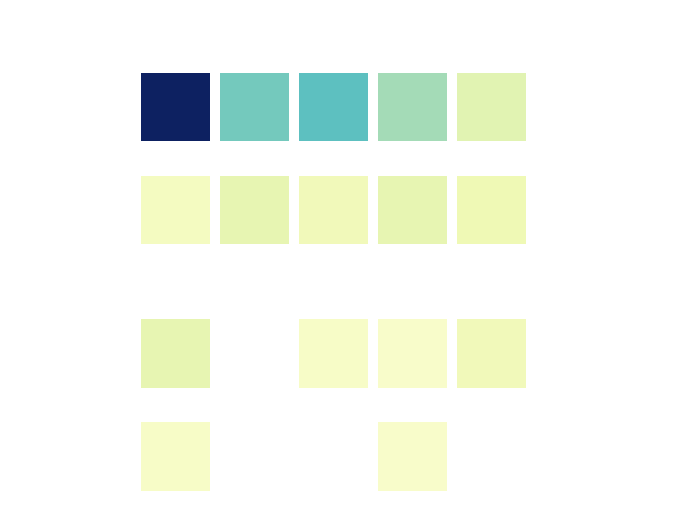

In [136]:
plot_ith_selection_new(d, 1, "rows", "1st_selection", cb=False)

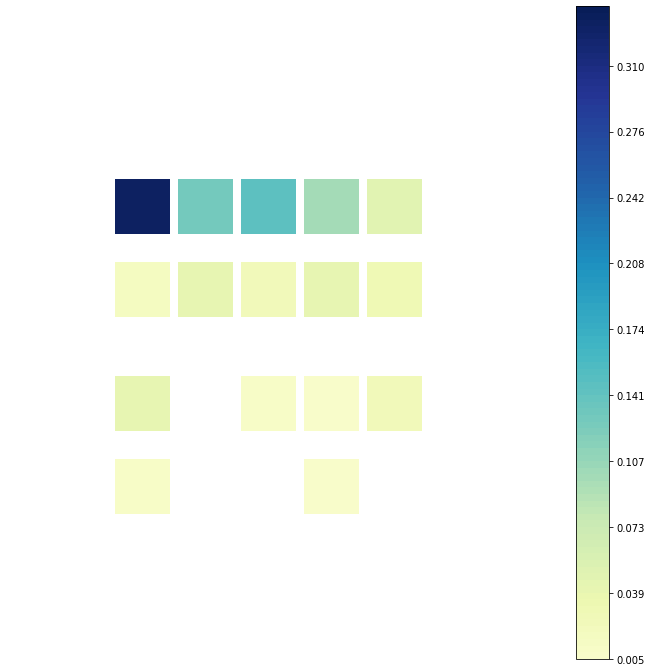

In [138]:
plot_ith_selection_new(d, 1, "rows", "1st_selection", cb=True)

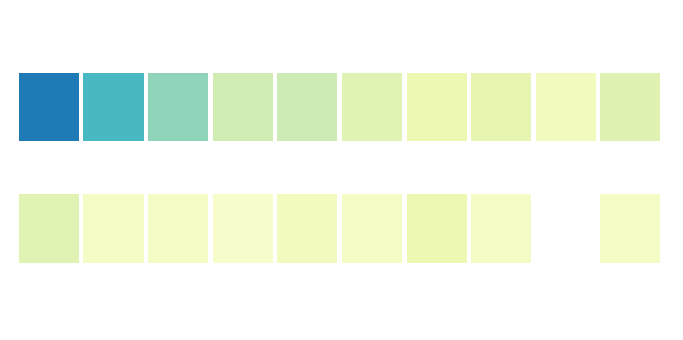

In [140]:
plot_ith_selection_new(d, 1, "row-single-scrollable", "1st_selection", img_w=175, h = 950, cb=False)

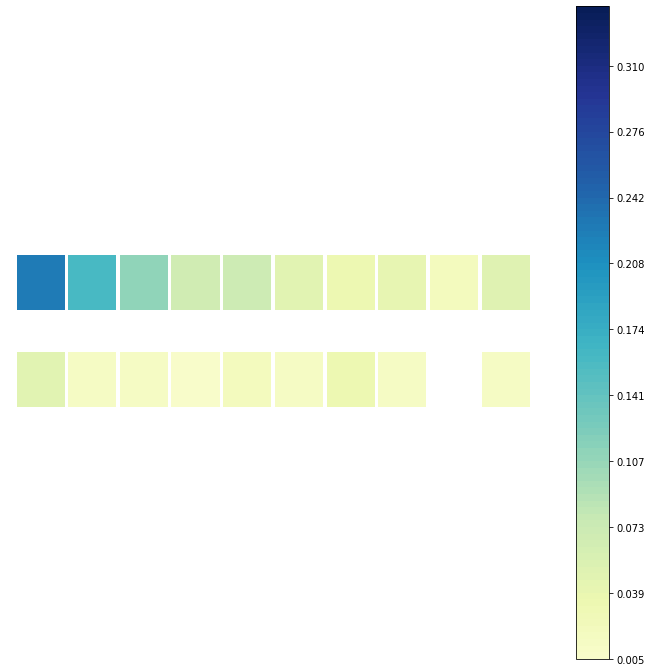

In [141]:
plot_ith_selection_new(d, 1, "row-single-scrollable", "1st_selection", img_w=175, h = 950, cb=True)

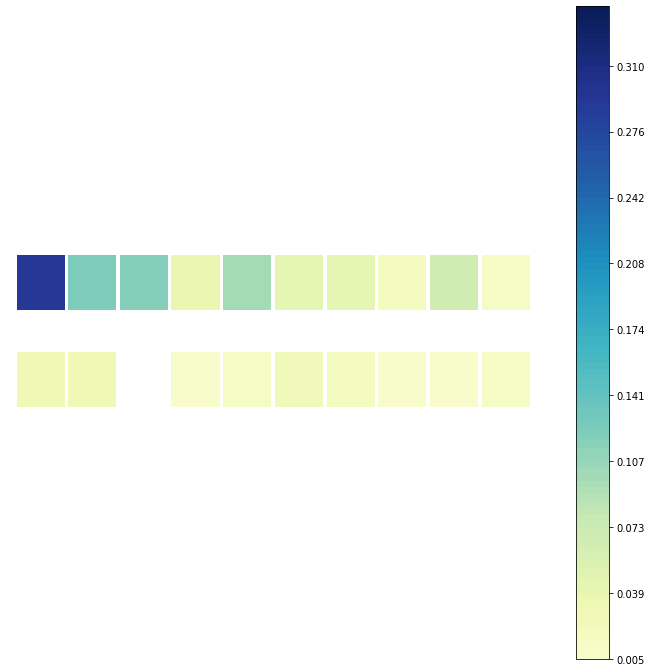

In [143]:
plot_ith_selection_new(d, 1, "row-single", "1st_selection", img_w=175, h = 950, cb = True)

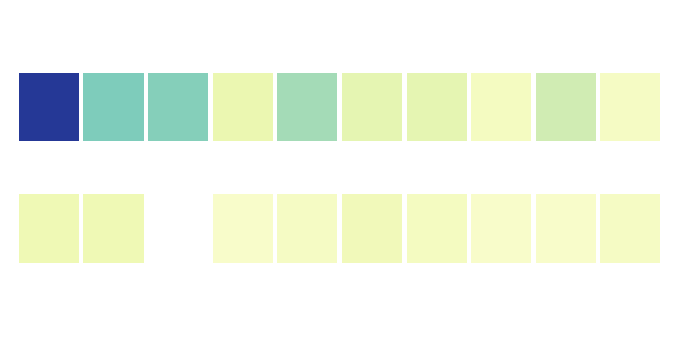

In [144]:
plot_ith_selection_new(d, 1, "row-single", "1st_selection", img_w=175, h = 950, cb = False)

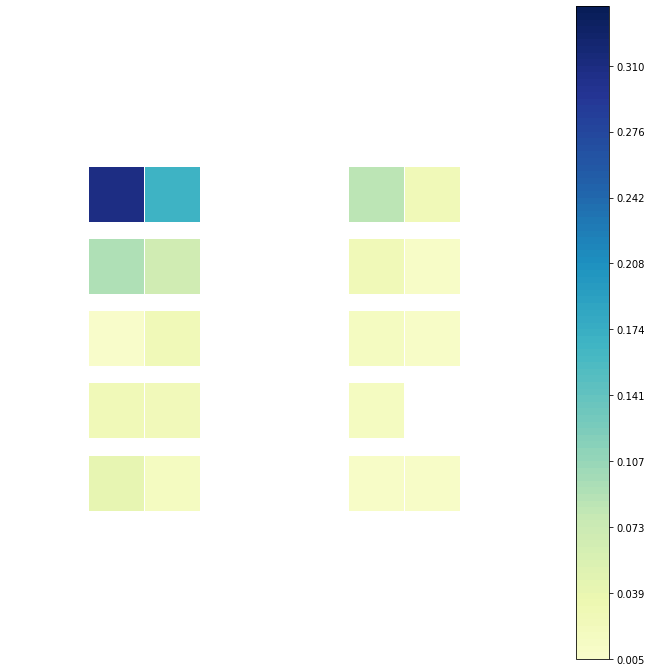

In [145]:
plot_ith_selection_new(d, 1, "columns", "1st_selection", h = 1600, cb=True)


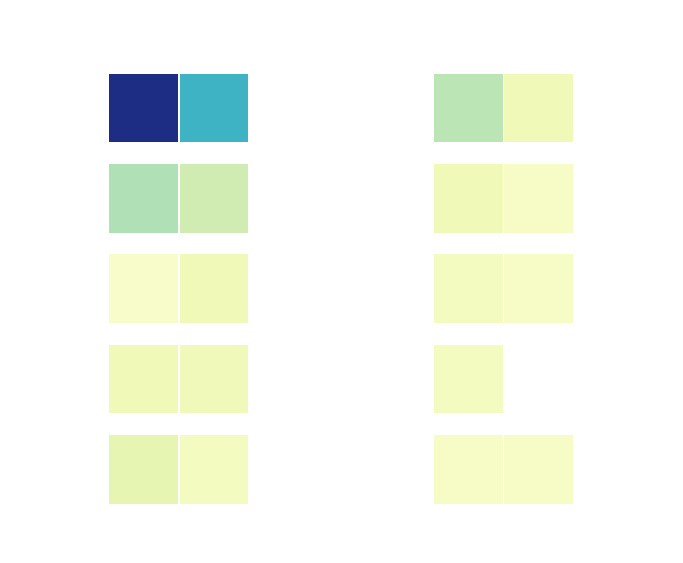

In [146]:
plot_ith_selection_new(d, 1, "columns", "1st_selection", h = 1600, cb=False)


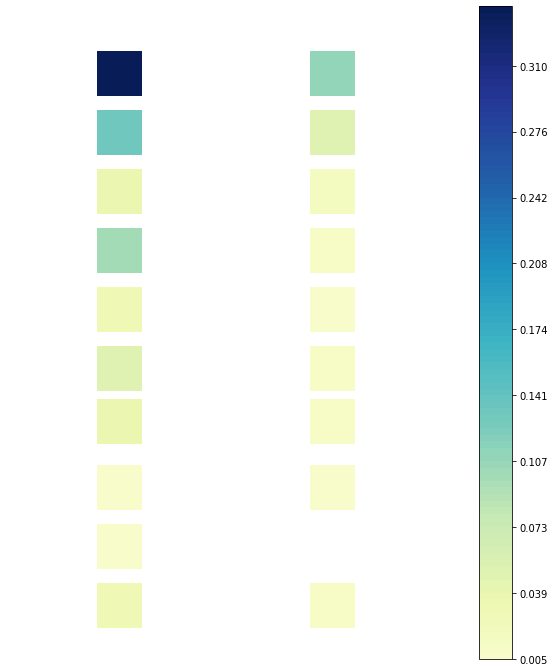

In [147]:
plot_ith_selection_new(d, 1, "column-single", "1st_selection", w=1950, h=2900, img_w = 200, img_h = 200, cb=True)


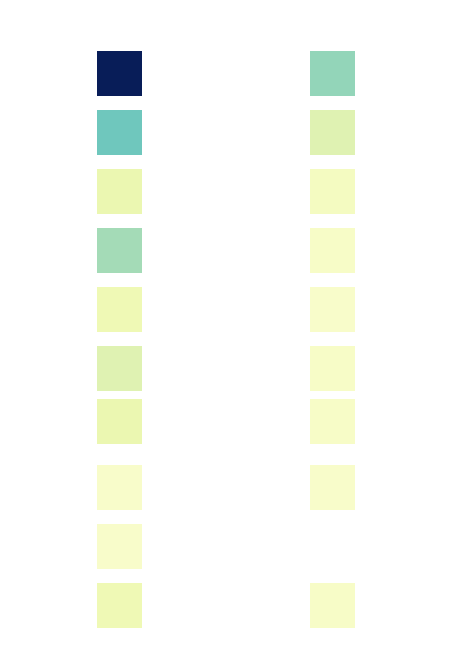

In [148]:
plot_ith_selection_new(d, 1, "column-single", "1st_selection", w=1950, h=2900, img_w = 200, img_h = 200, cb=False)


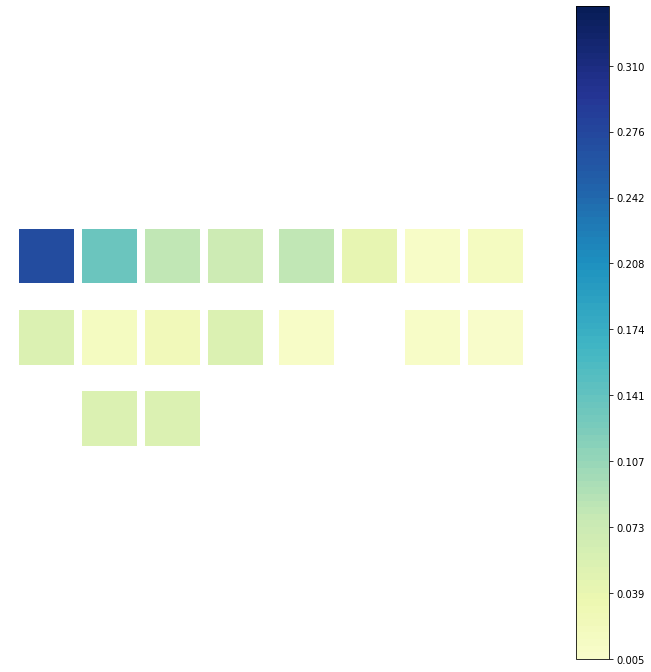

In [149]:
plot_ith_selection_new(d, 1, "max-columns", "1st_selection", h = 1150, cb=True)

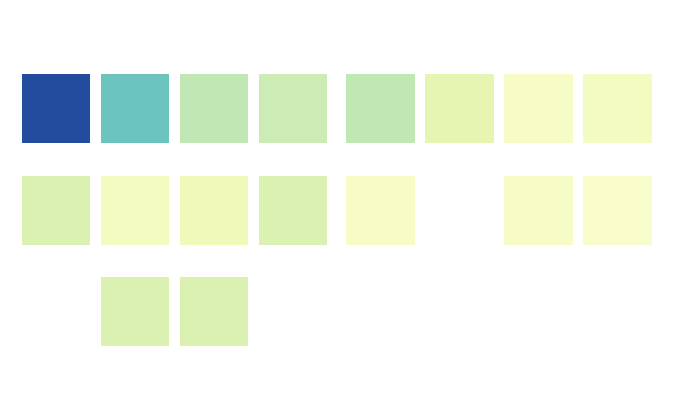

In [150]:
plot_ith_selection_new(d, 1, "max-columns", "1st_selection", h = 1150, cb=False)

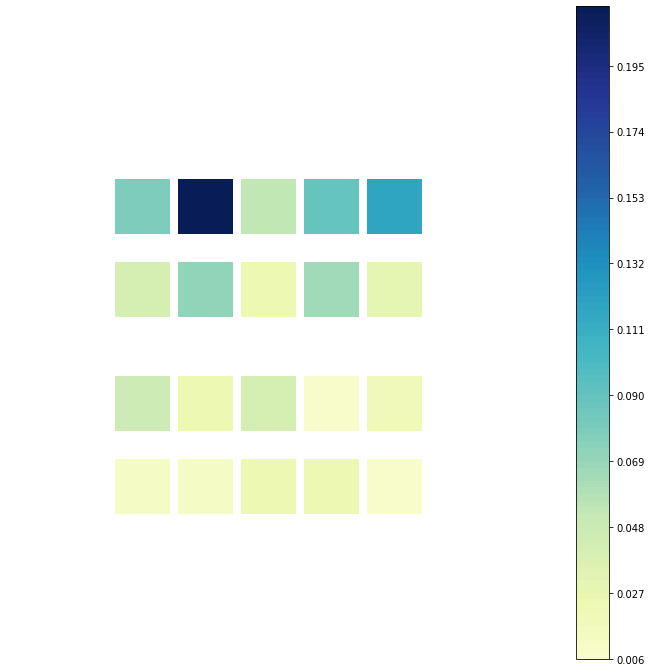

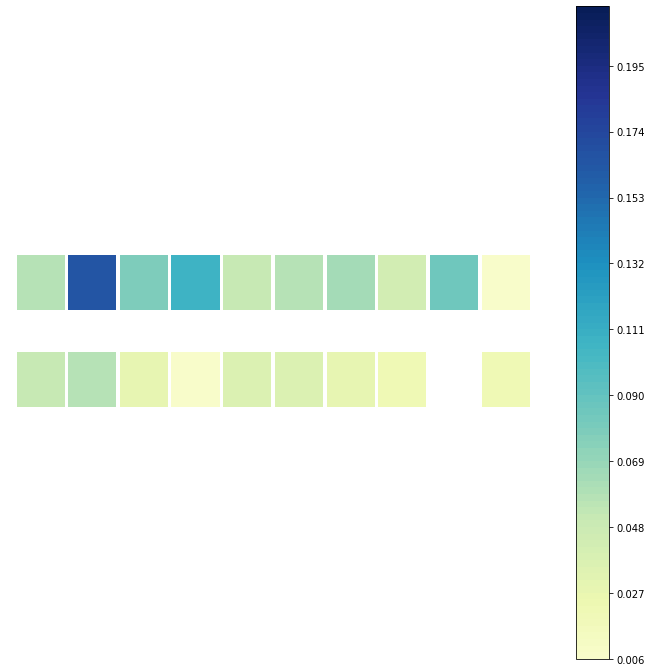

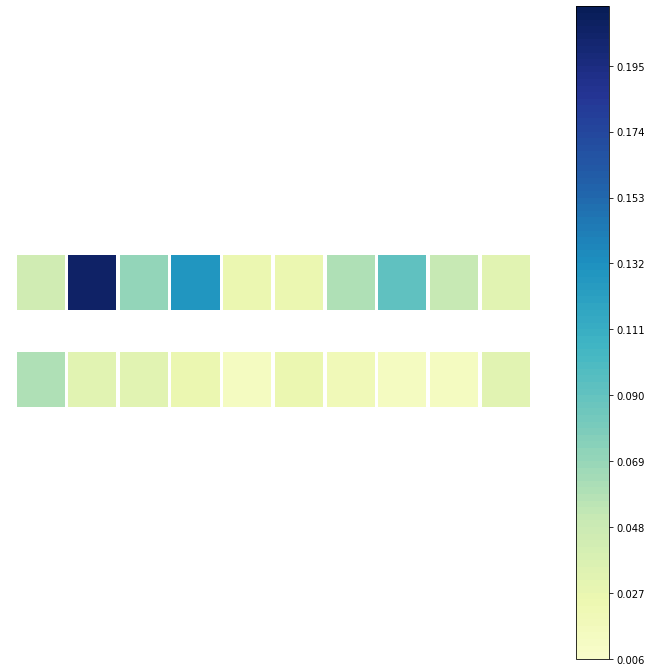

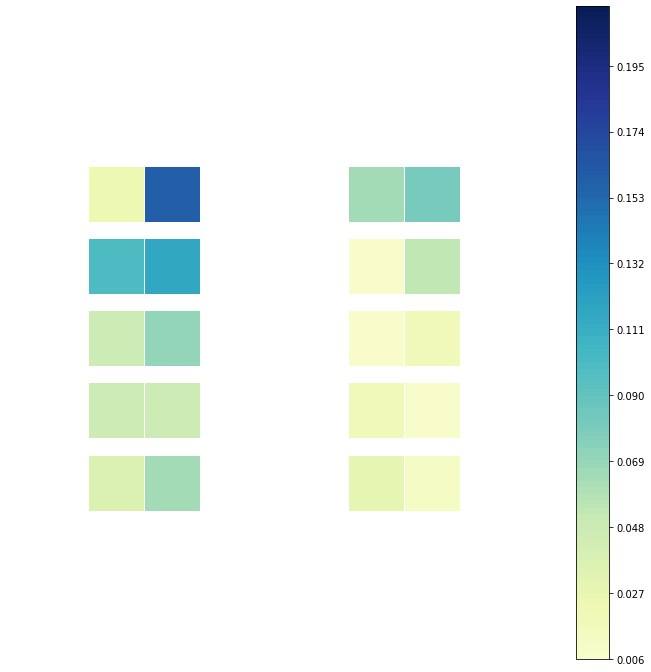

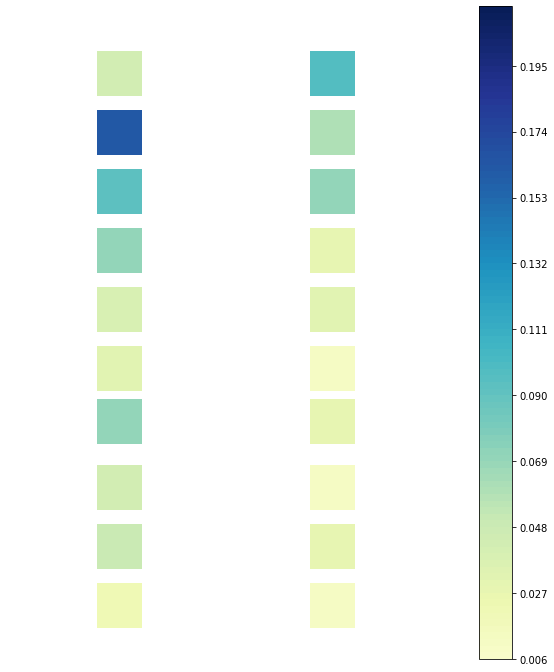

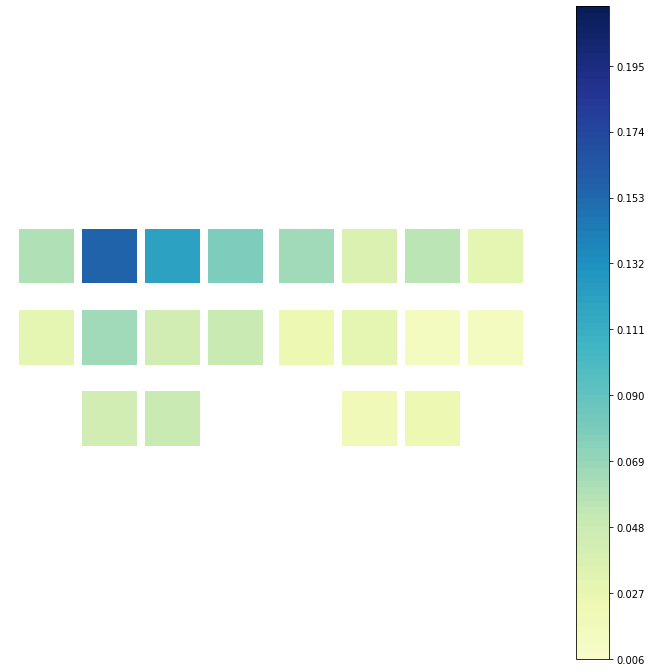

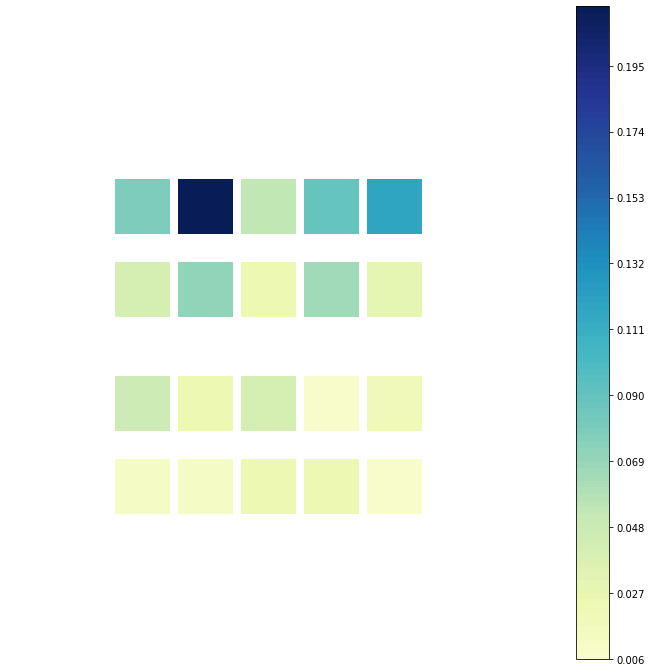

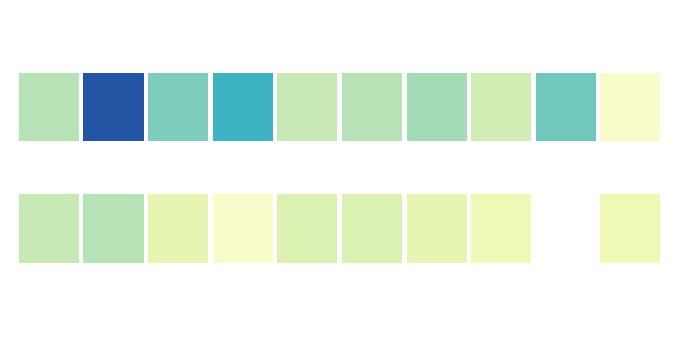

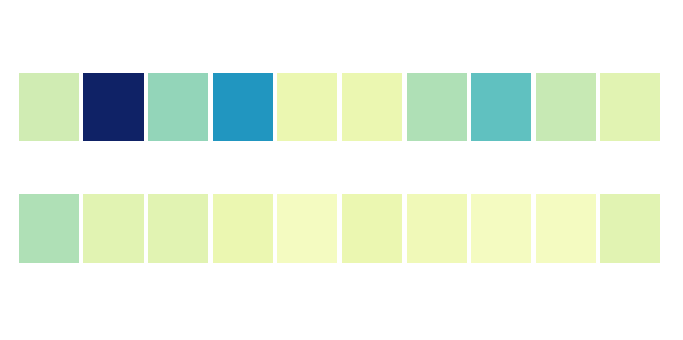

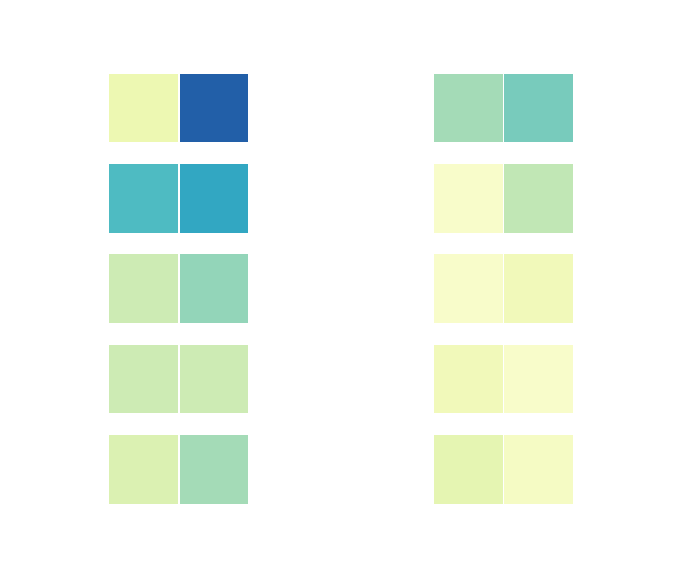

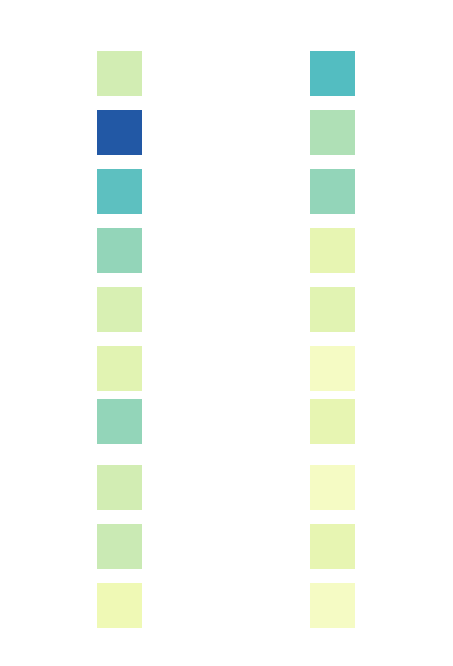

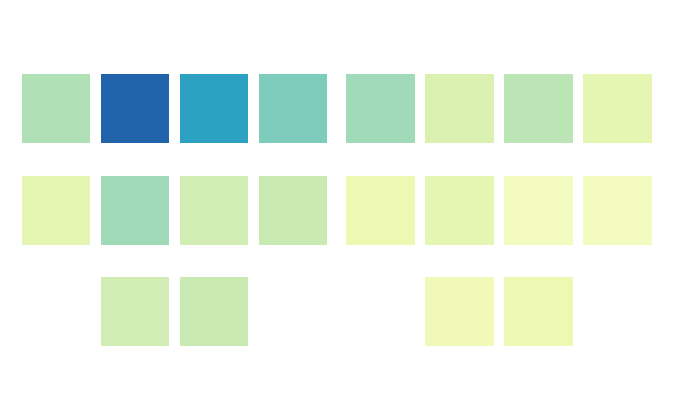

In [151]:
plot_ith_selection_new(d, 2, "rows", "2nd_selection", cb=True)
plot_ith_selection_new(d, 2, "row-single-scrollable", "2nd_selection", img_w=175, h = 950, cb=True)
plot_ith_selection_new(d, 2, "row-single", "2nd_selection", img_w=175, h = 950, cb = True)
plot_ith_selection_new(d, 2, "columns", "2nd_selection", h = 1600, cb=True)
plot_ith_selection_new(d, 2, "column-single", "2nd_selection", w=1950, h=2900, img_w = 200, img_h = 200, cb=True)
plot_ith_selection_new(d, 2, "max-columns", "2nd_selection", h = 1150, cb=True)

plot_ith_selection_new(d, 2, "rows", "2nd_selection", cb=False)
plot_ith_selection_new(d, 2, "row-single-scrollable", "2nd_selection", img_w=175, h = 950, cb=False)
plot_ith_selection_new(d, 2, "row-single", "2nd_selection", img_w=175, h = 950, cb = False)
plot_ith_selection_new(d, 2, "columns", "2nd_selection", h = 1600, cb=False)
plot_ith_selection_new(d, 2, "column-single", "2nd_selection", w=1950, h=2900, img_w = 200, img_h = 200, cb=False)
plot_ith_selection_new(d, 2, "max-columns", "2nd_selection", h = 1150, cb=False)

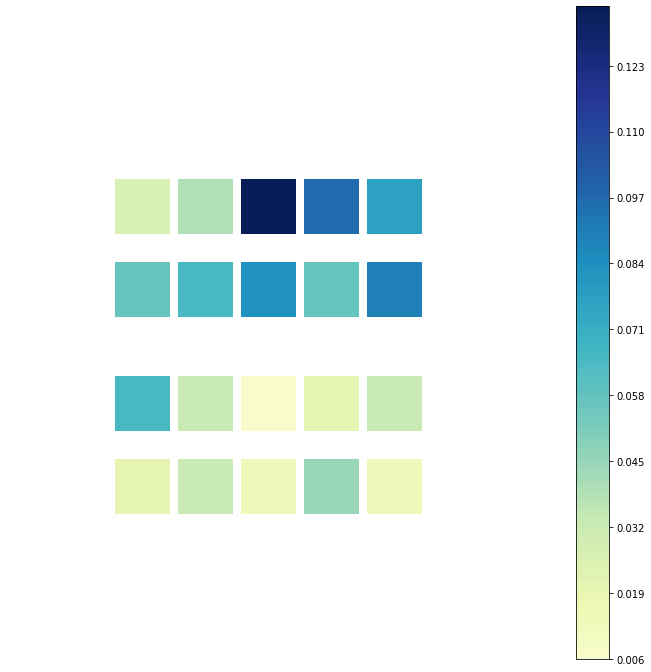

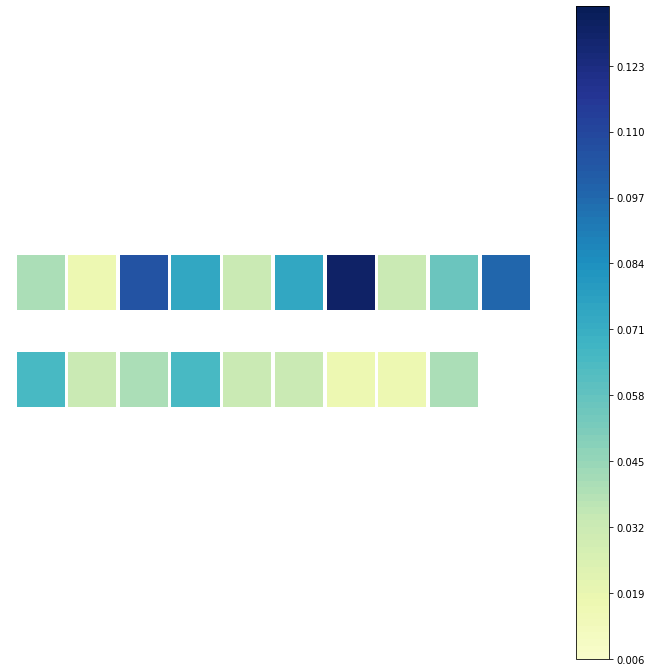

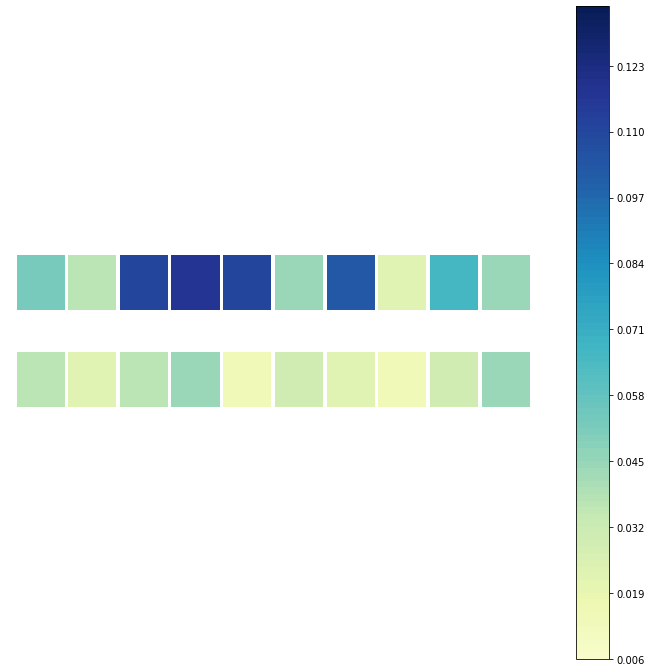

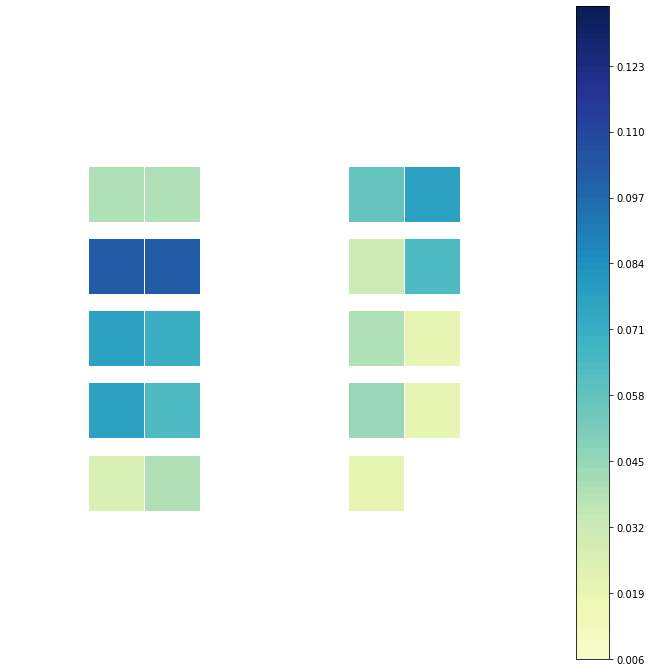

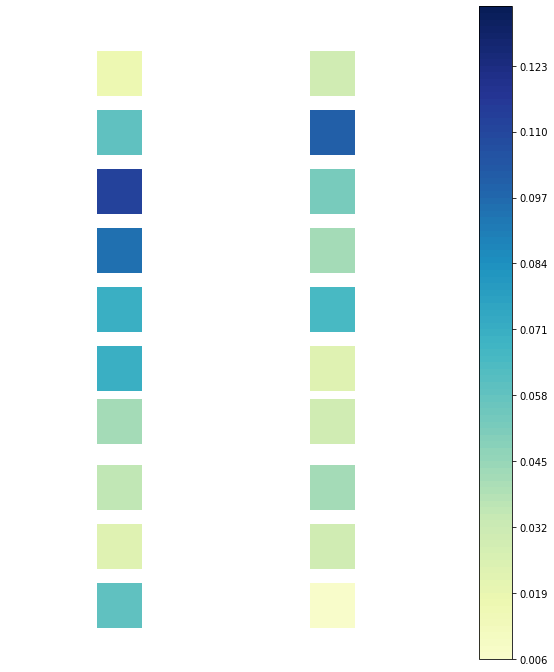

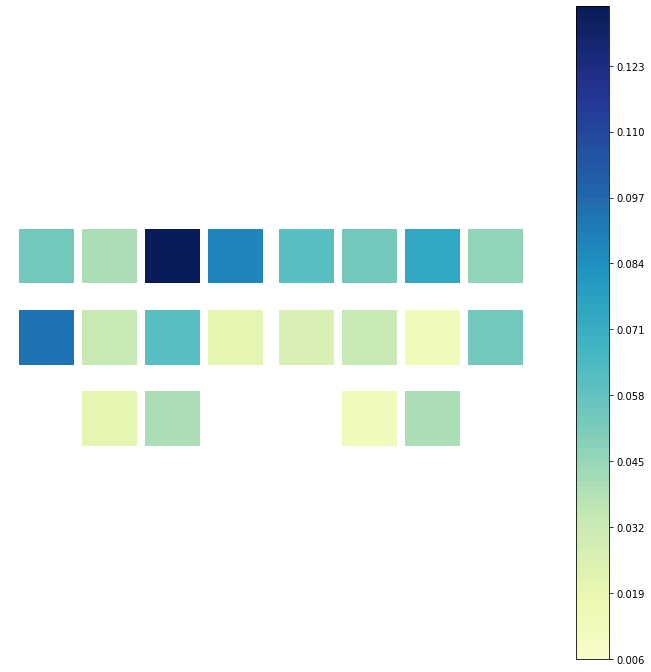

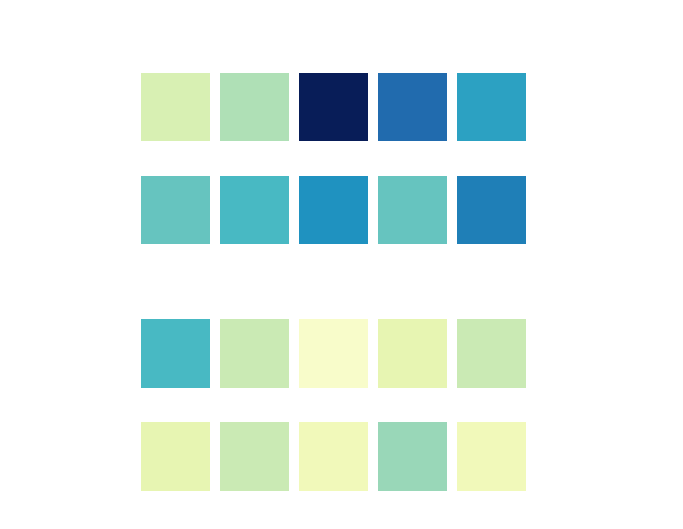

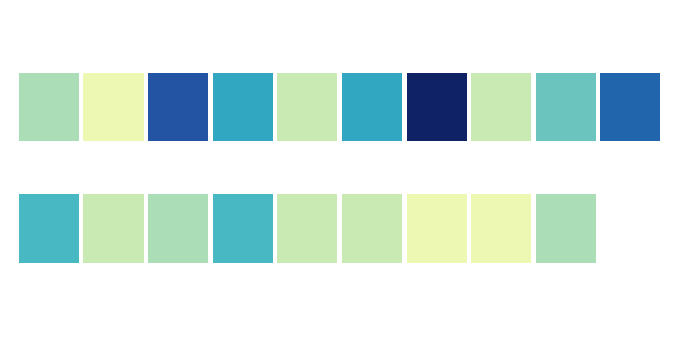

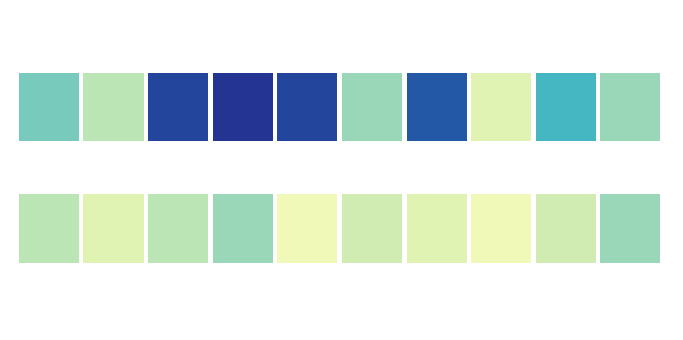

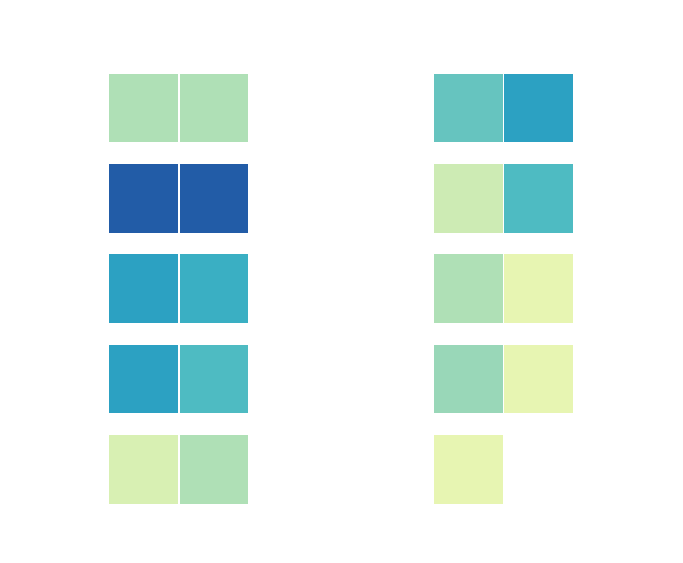

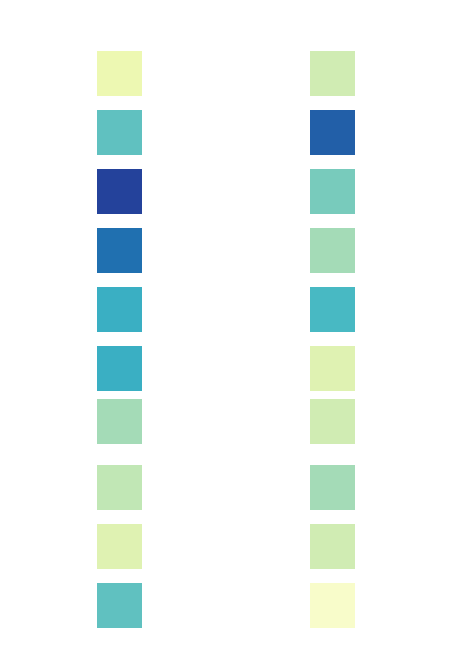

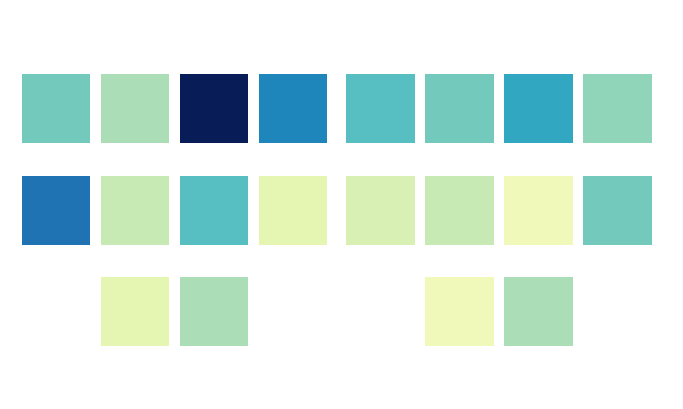

In [152]:
plot_ith_selection_new(d, 3, "rows", "3rd_selection", cb=True)
plot_ith_selection_new(d, 3, "row-single-scrollable", "3rd_selection", img_w=175, h = 950, cb=True)
plot_ith_selection_new(d, 3, "row-single", "3rd_selection", img_w=175, h = 950, cb = True)
plot_ith_selection_new(d, 3, "columns", "3rd_selection", h = 1600, cb=True)
plot_ith_selection_new(d, 3, "column-single", "3rd_selection", w=1950, h=2900, img_w = 200, img_h = 200, cb=True)
plot_ith_selection_new(d, 3, "max-columns", "3rd_selection", h = 1150, cb=True)

plot_ith_selection_new(d, 3, "rows", "3rd_selection", cb=False)
plot_ith_selection_new(d, 3, "row-single-scrollable", "3rd_selection", img_w=175, h = 950, cb=False)
plot_ith_selection_new(d, 3, "row-single", "3rd_selection", img_w=175, h = 950, cb = False)
plot_ith_selection_new(d, 3, "columns", "3rd_selection", h = 1600, cb=False)
plot_ith_selection_new(d, 3, "column-single", "3rd_selection", w=1950, h=2900, img_w = 200, img_h = 200, cb=False)
plot_ith_selection_new(d, 3, "max-columns", "3rd_selection", h = 1150, cb=False)

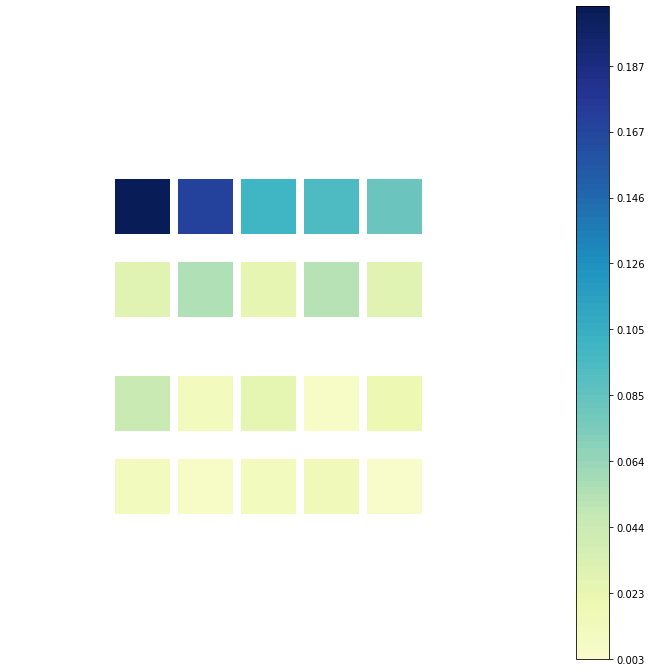

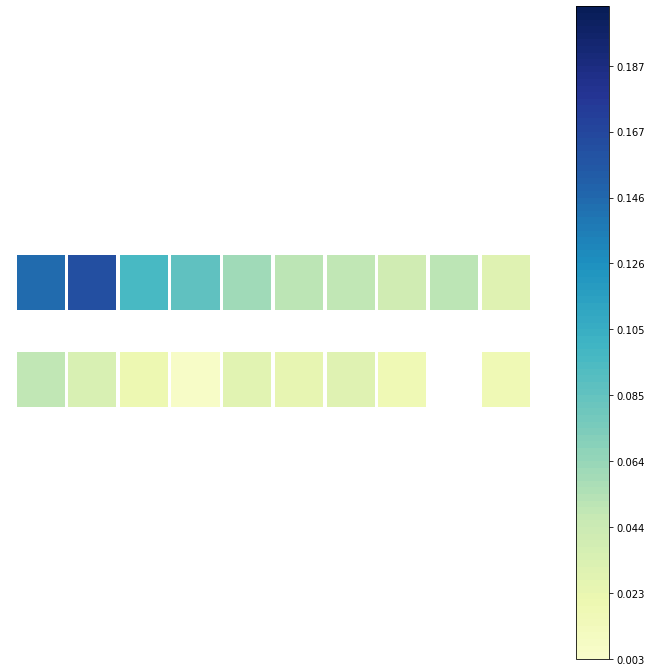

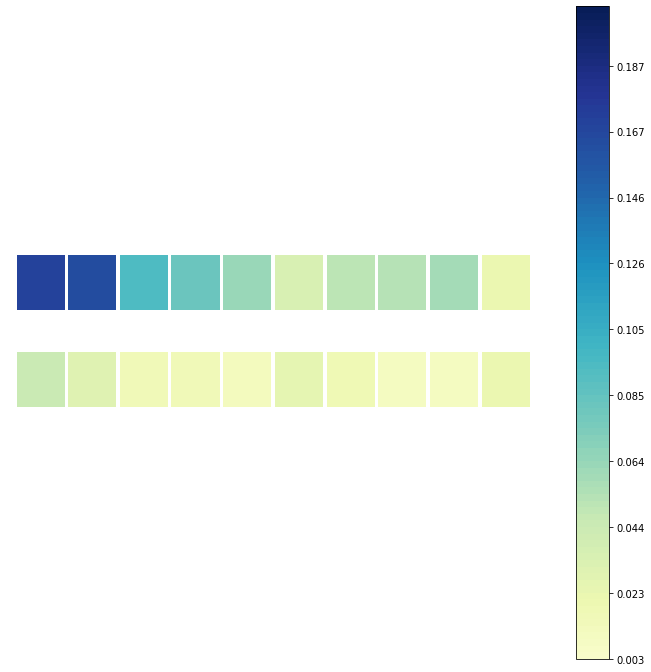

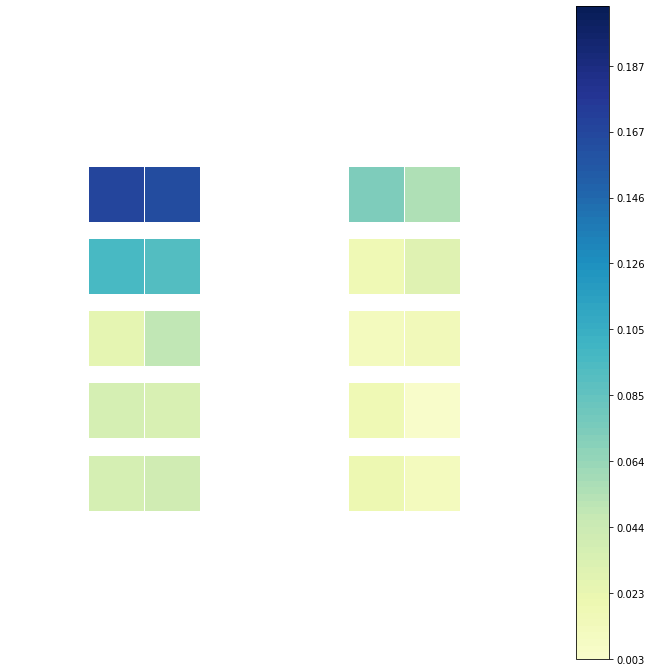

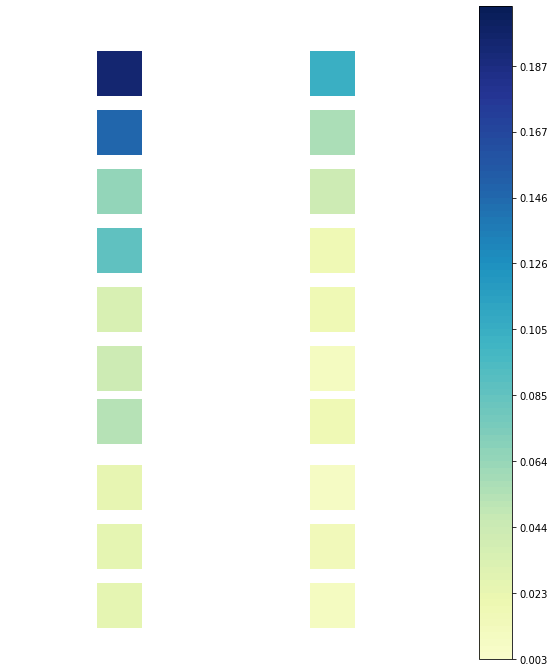

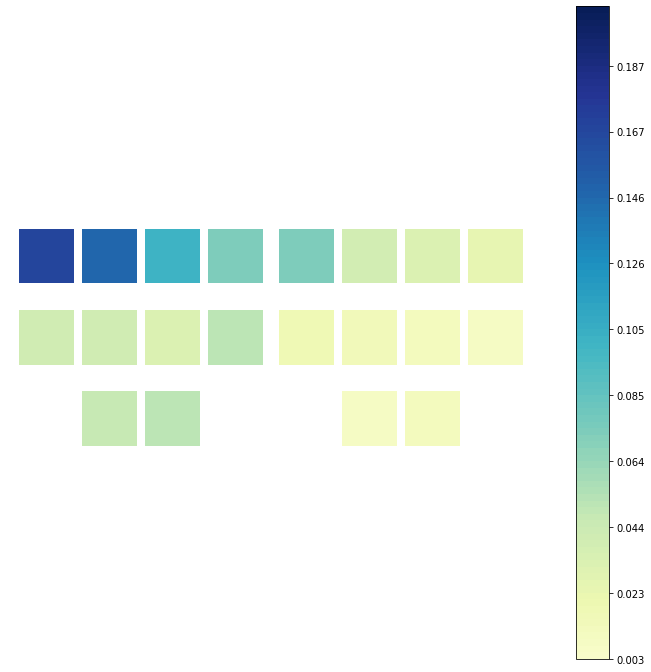

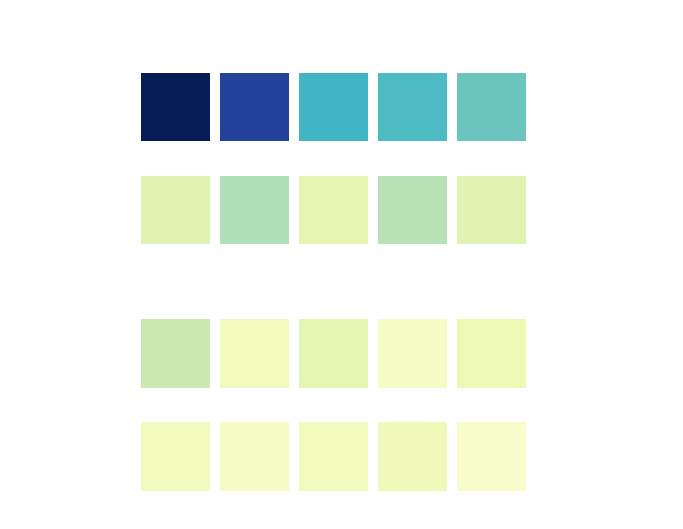

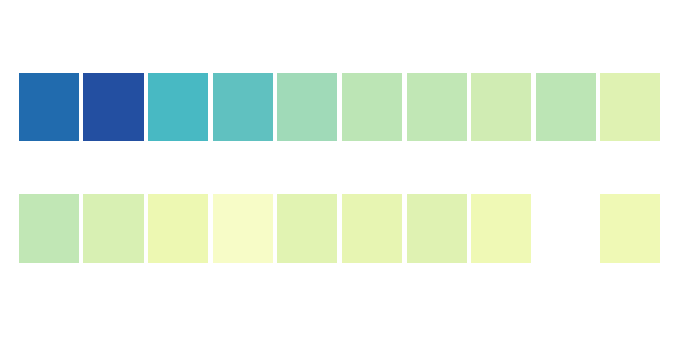

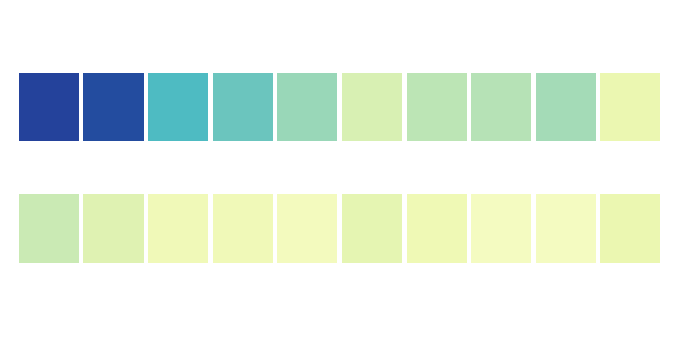

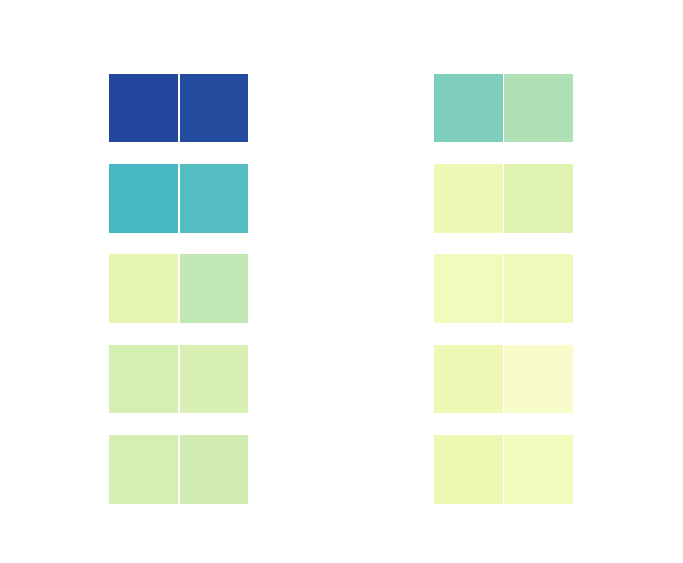

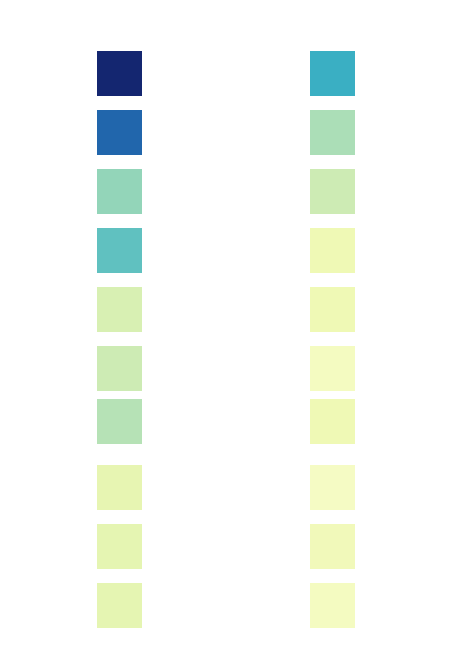

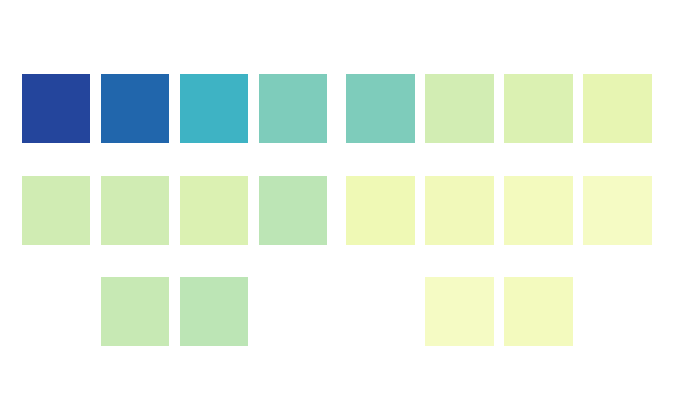

In [153]:
plot_within_ith_selection_new(d, 2, "rows", "within_2_selection", cb=True)
plot_within_ith_selection_new(d, 2, "row-single-scrollable", "within_2_selection", img_w=175, h = 950, cb=True)
plot_within_ith_selection_new(d, 2, "row-single", "within_2_selection", img_w=175, h = 950, cb = True)
plot_within_ith_selection_new(d, 2, "columns", "within_2_selection", h = 1600, cb=True)
plot_within_ith_selection_new(d, 2, "column-single", "within_2_selection", w=1950, h=2900, img_w = 200, img_h = 200, cb=True)
plot_within_ith_selection_new(d, 2, "max-columns", "within_2_selection", h = 1150, cb=True)
plot_within_ith_selection_new(d, 2, "rows", "within_2_selection", cb=False)
plot_within_ith_selection_new(d, 2, "row-single-scrollable", "within_2_selection", img_w=175, h = 950, cb=False)
plot_within_ith_selection_new(d, 2, "row-single", "within_2_selection", img_w=175, h = 950, cb = False)
plot_within_ith_selection_new(d, 2, "columns", "within_2_selection", h = 1600, cb=False)
plot_within_ith_selection_new(d, 2, "column-single", "within_2_selection", w=1950, h=2900, img_w = 200, img_h = 200, cb=False)
plot_within_ith_selection_new(d, 2, "max-columns", "within_2_selection", h = 1150, cb=False)

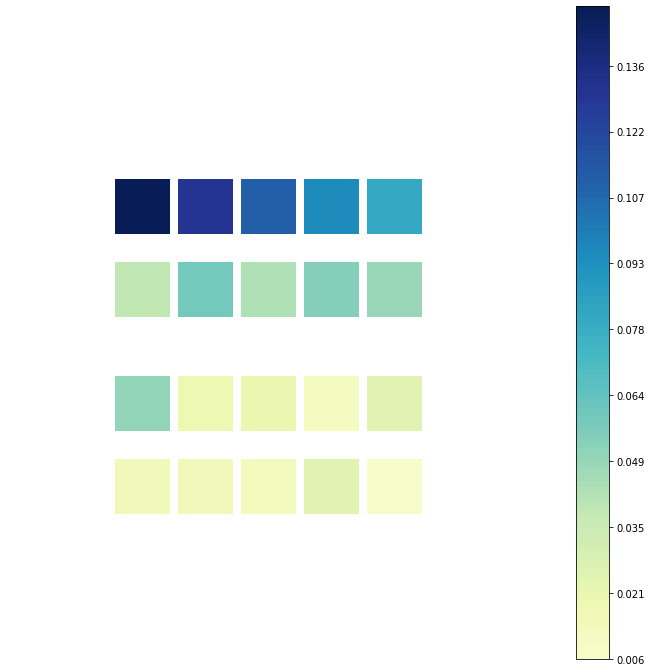

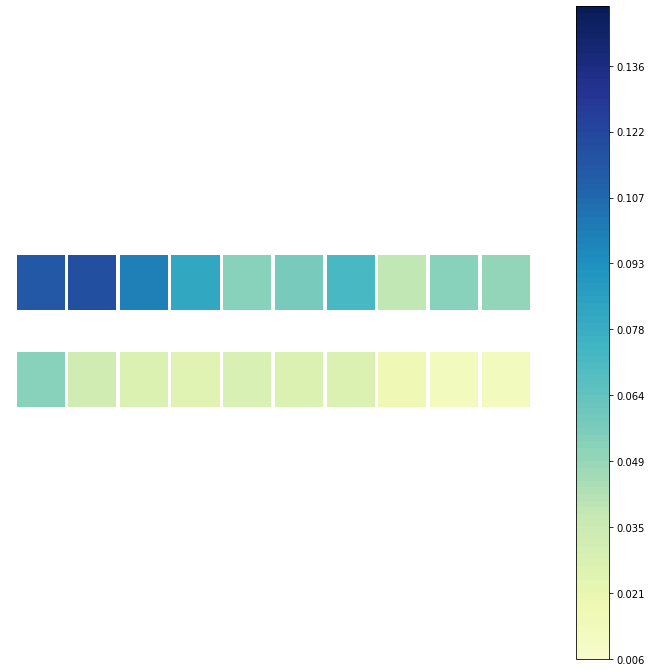

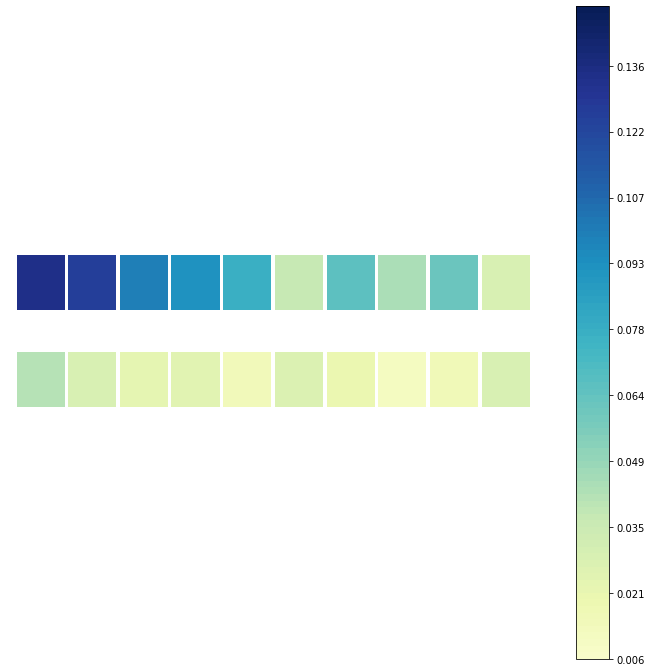

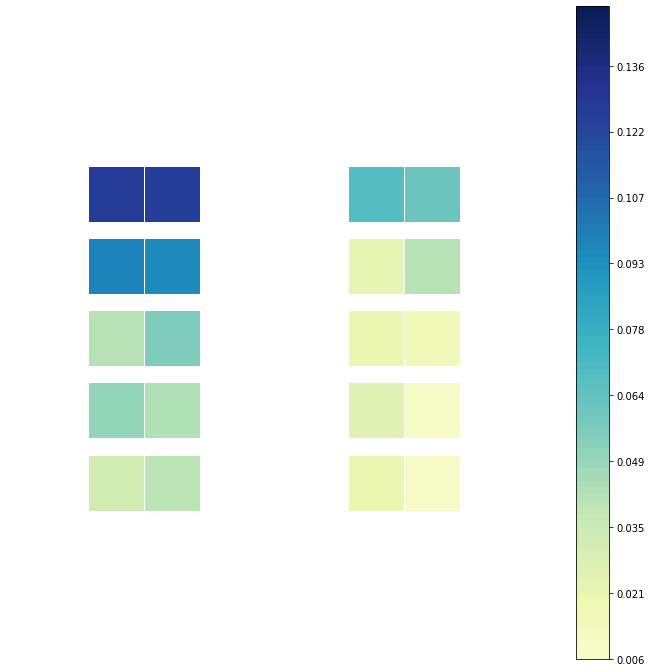

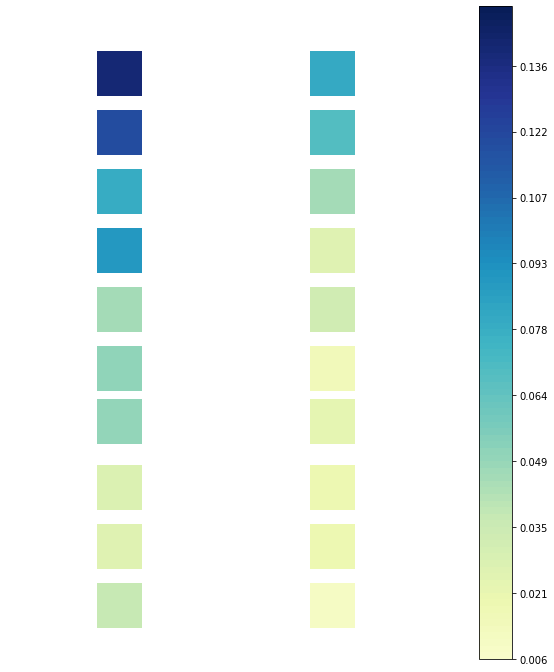

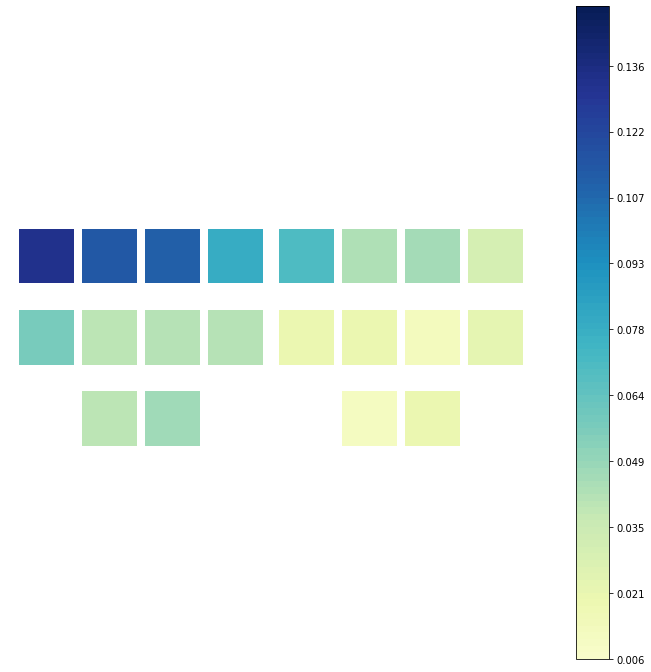

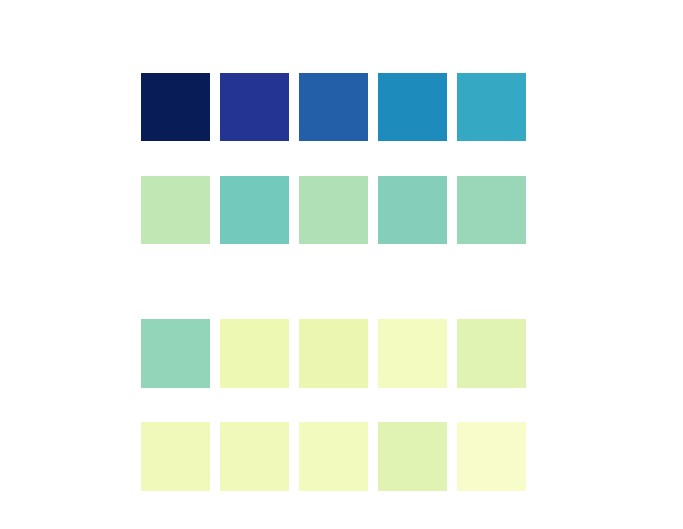

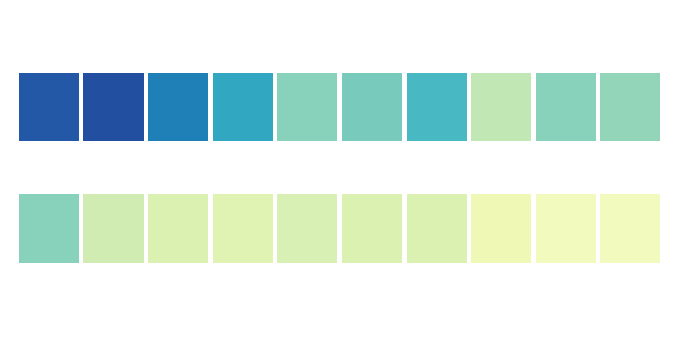

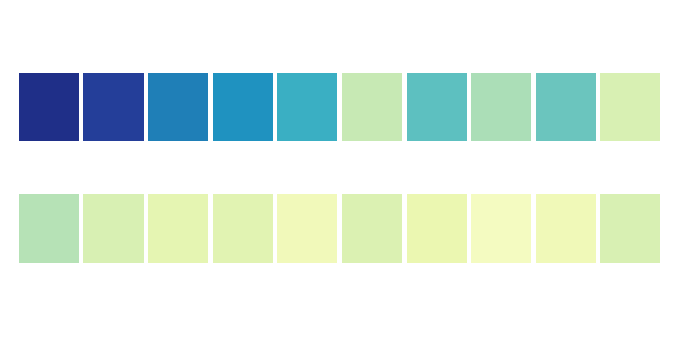

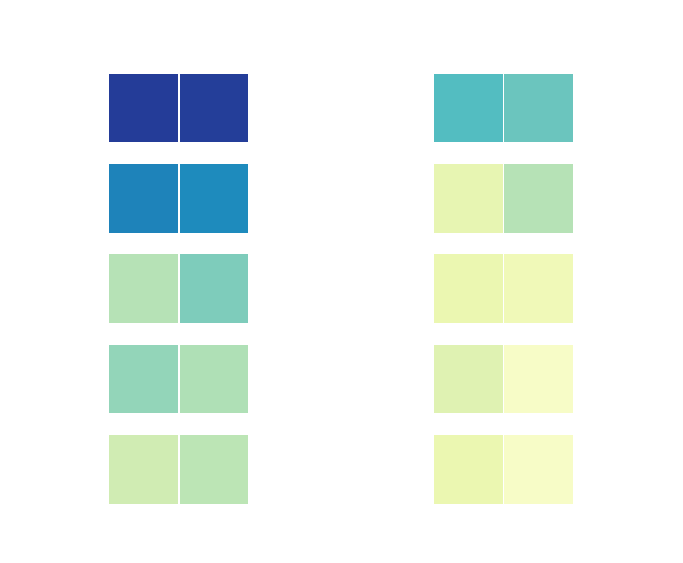

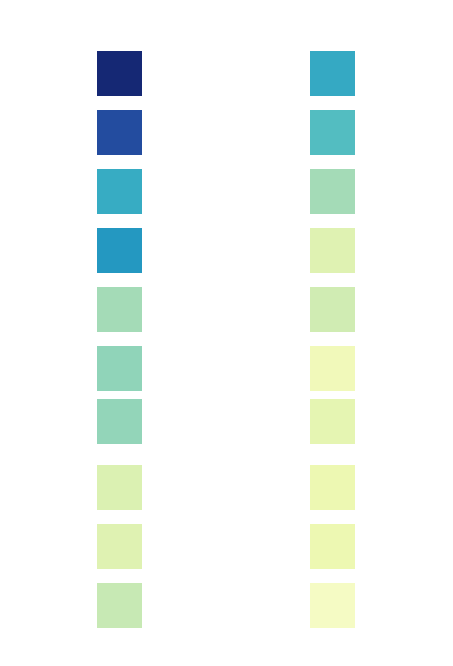

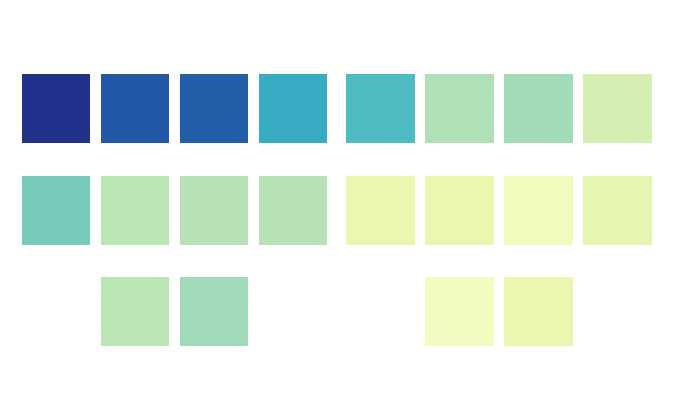

In [154]:
plot_within_ith_selection_new(d, 3, "rows", "within_3_selection", cb=True)
plot_within_ith_selection_new(d, 3, "row-single-scrollable", "within_3_selection", img_w=175, h = 950, cb=True)
plot_within_ith_selection_new(d, 3, "row-single", "within_3_selection", img_w=175, h = 950, cb = True)
plot_within_ith_selection_new(d, 3, "columns", "within_3_selection", h = 1600, cb=True)
plot_within_ith_selection_new(d, 3, "column-single", "within_3_selection", w=1950, h=2900, img_w = 200, img_h = 200, cb=True)
plot_within_ith_selection_new(d, 3, "max-columns", "within_3_selection", h = 1150, cb=True)
plot_within_ith_selection_new(d, 3, "rows", "within_3_selection", cb=False)
plot_within_ith_selection_new(d, 3, "row-single-scrollable", "within_3_selection", img_w=175, h = 950, cb=False)
plot_within_ith_selection_new(d, 3, "row-single", "within_3_selection", img_w=175, h = 950, cb = False)
plot_within_ith_selection_new(d, 3, "columns", "within_3_selection", h = 1600, cb=False)
plot_within_ith_selection_new(d, 3, "column-single", "within_3_selection", w=1950, h=2900, img_w = 200, img_h = 200, cb=False)
plot_within_ith_selection_new(d, 3, "max-columns", "within_3_selection", h = 1150, cb=False)

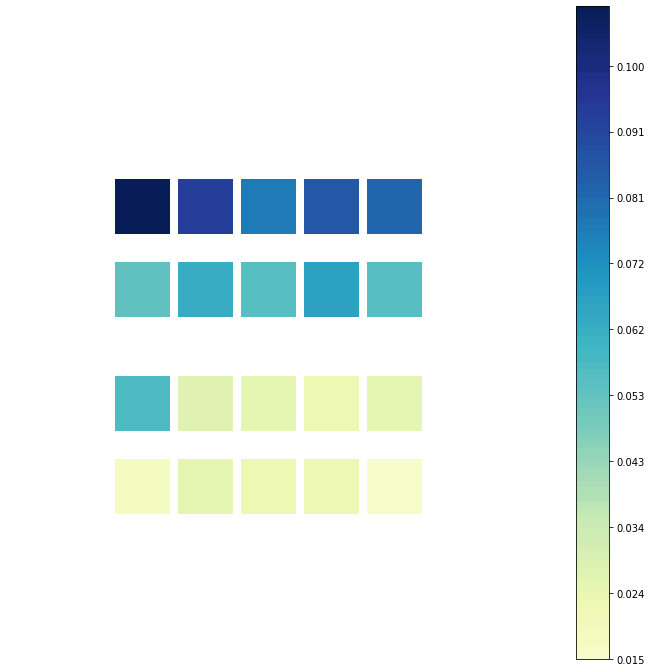

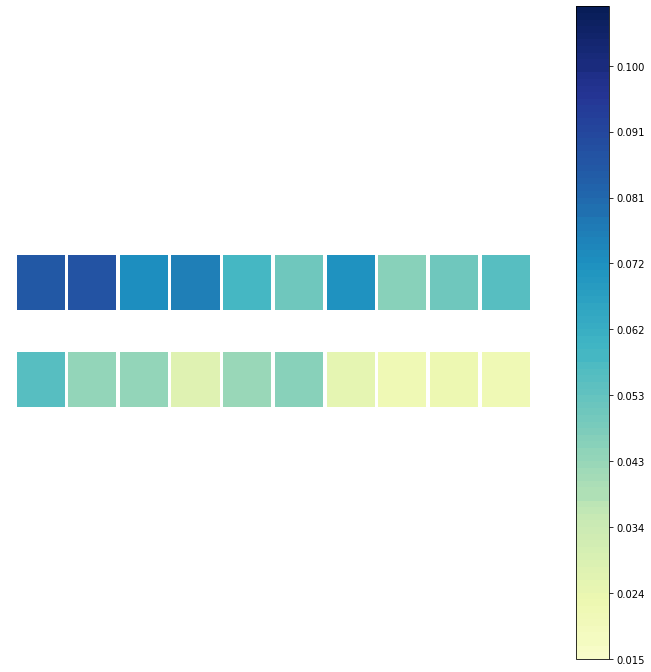

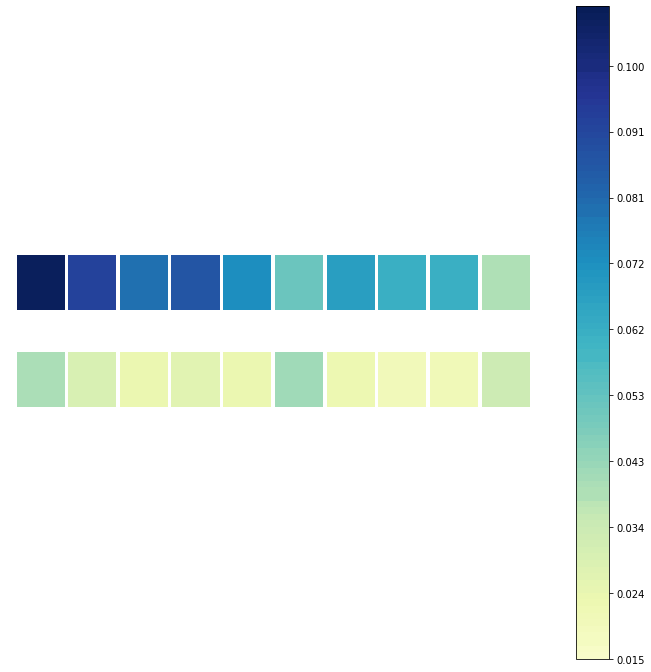

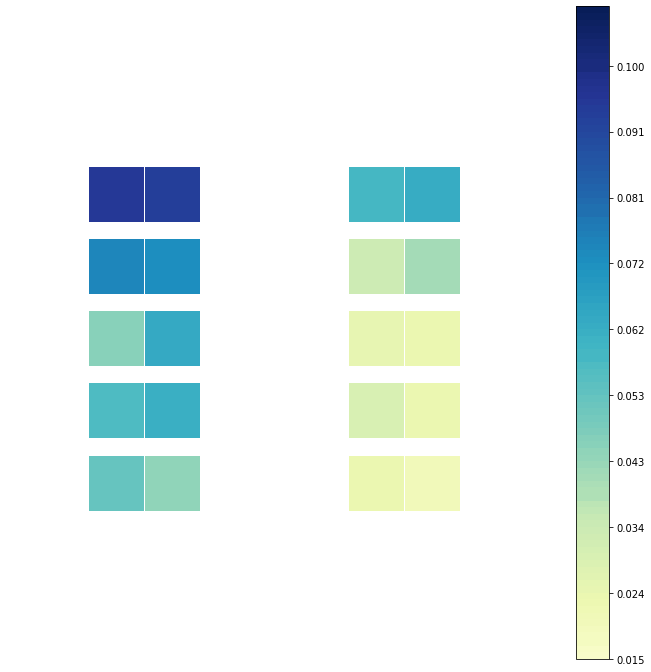

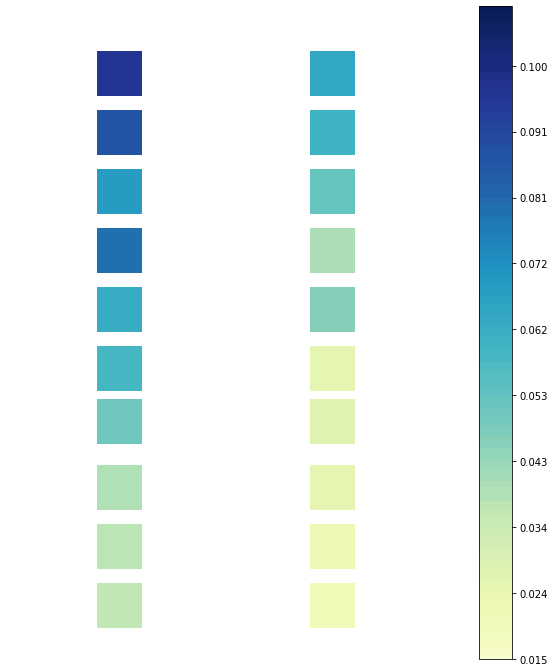

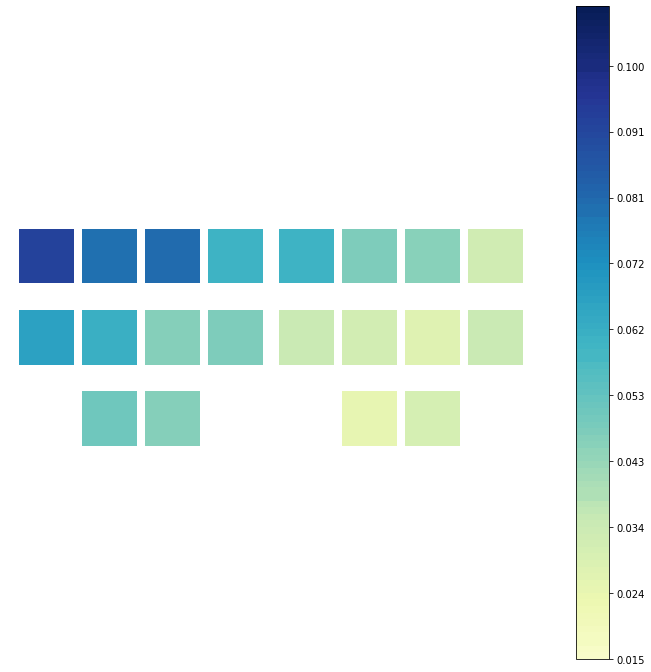

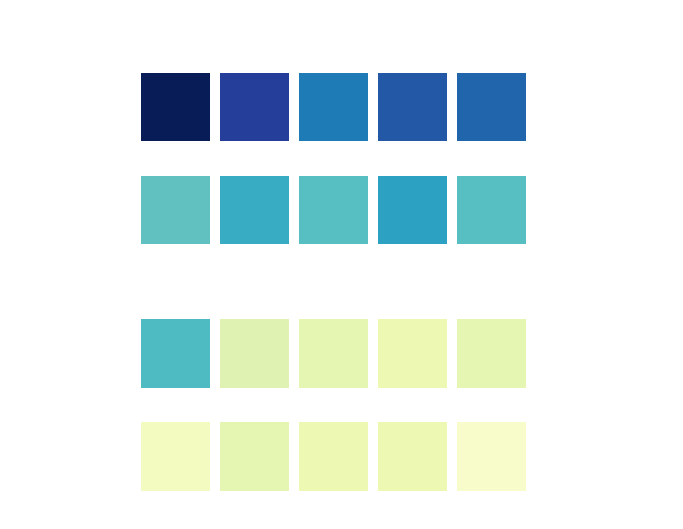

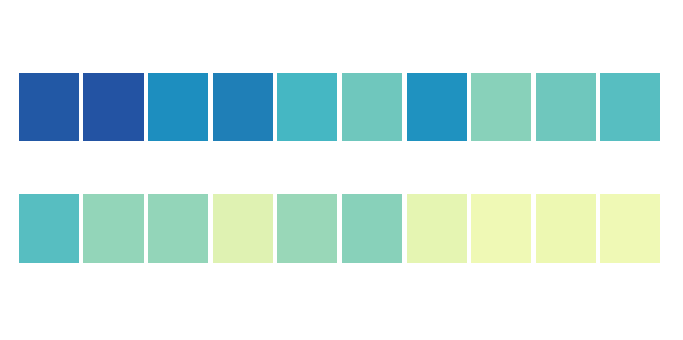

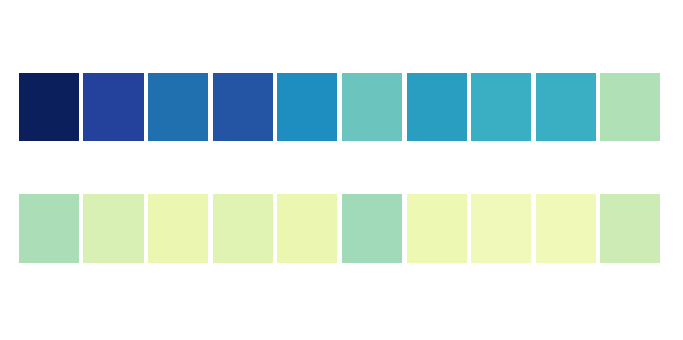

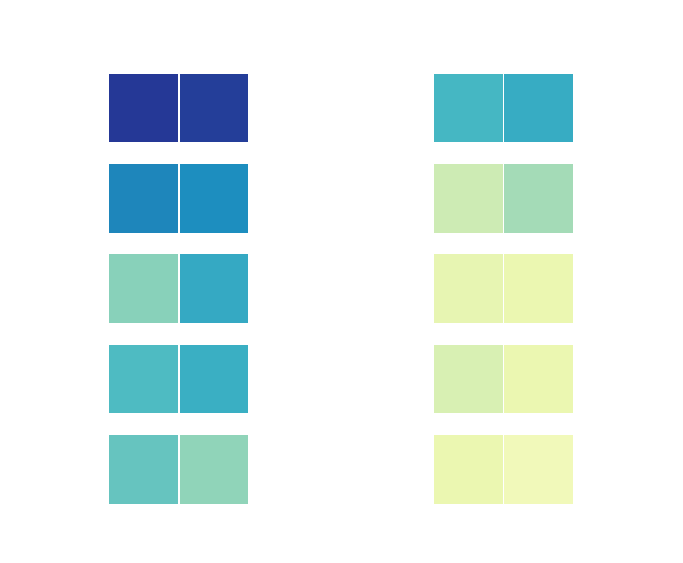

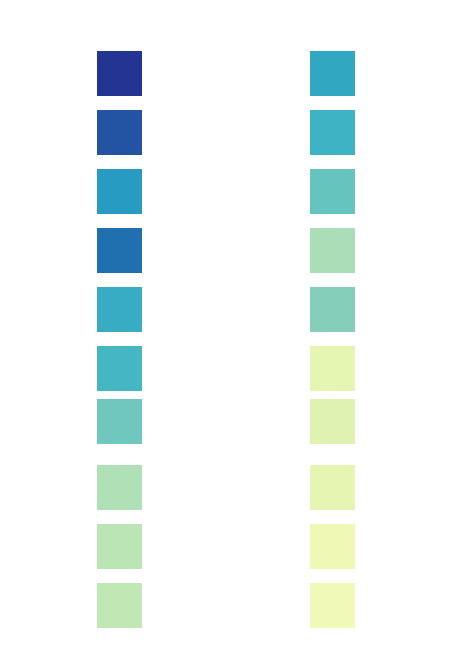

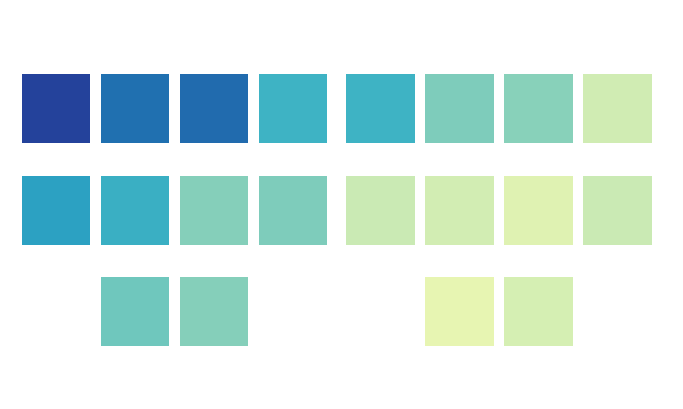

In [155]:
plot_within_ith_selection_new(d, 5, "rows", "within_5_selection", cb=True)
plot_within_ith_selection_new(d, 5, "row-single-scrollable", "within_5_selection", img_w=175, h = 950, cb=True)
plot_within_ith_selection_new(d, 5, "row-single", "within_5_selection", img_w=175, h = 950, cb = True)
plot_within_ith_selection_new(d, 5, "columns", "within_5_selection", h = 1600, cb=True)
plot_within_ith_selection_new(d, 5, "column-single", "within_5_selection", w=1950, h=2900, img_w = 200, img_h = 200, cb=True)
plot_within_ith_selection_new(d, 5, "max-columns", "within_5_selection", h = 1150, cb=True)
plot_within_ith_selection_new(d, 5, "rows", "within_5_selection", cb=False)
plot_within_ith_selection_new(d, 5, "row-single-scrollable", "within_5_selection", img_w=175, h = 950, cb=False)
plot_within_ith_selection_new(d, 5, "row-single", "within_5_selection", img_w=175, h = 950, cb = False)
plot_within_ith_selection_new(d, 5, "columns", "within_5_selection", h = 1600, cb=False)
plot_within_ith_selection_new(d, 5, "column-single", "within_5_selection", w=1950, h=2900, img_w = 200, img_h = 200, cb=False)
plot_within_ith_selection_new(d, 5, "max-columns", "within_5_selection", h = 1150, cb=False)

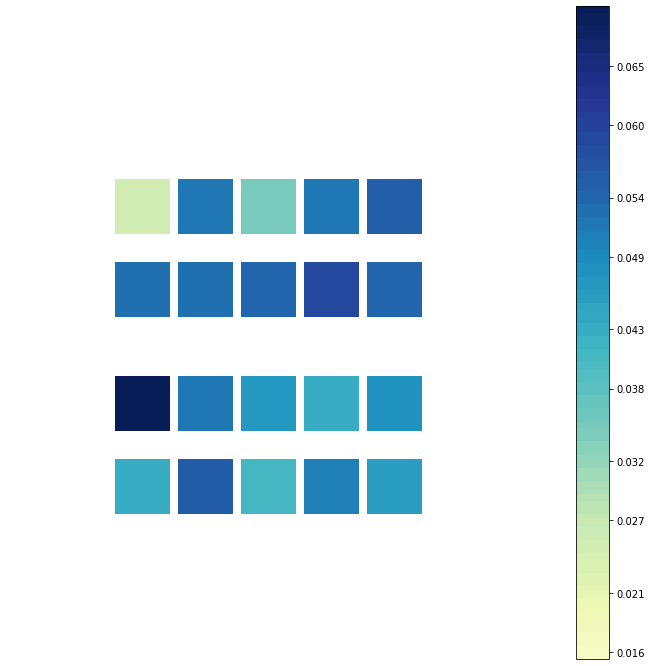

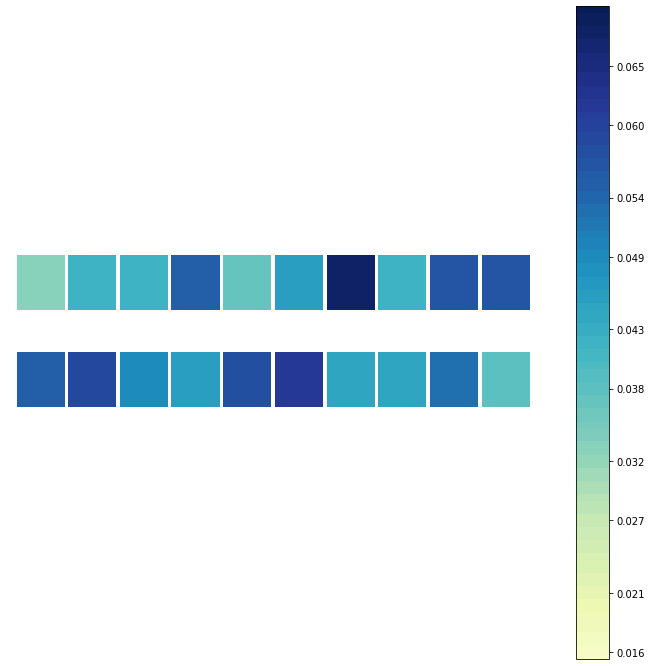

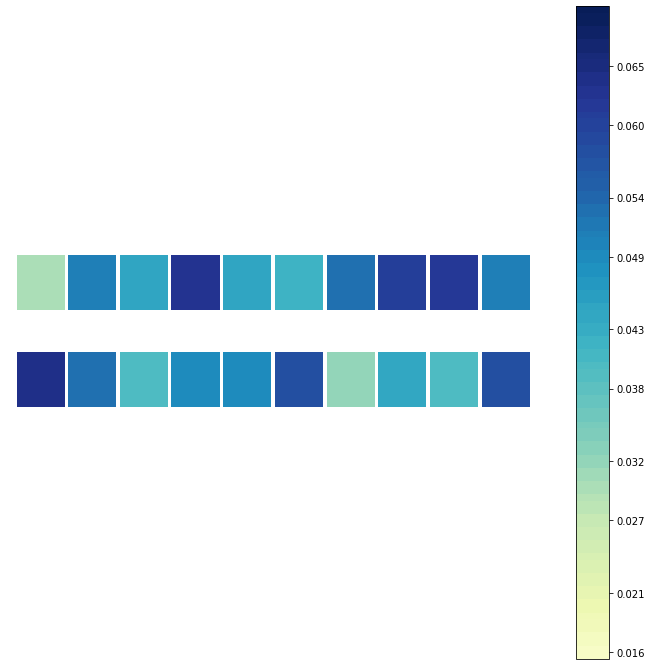

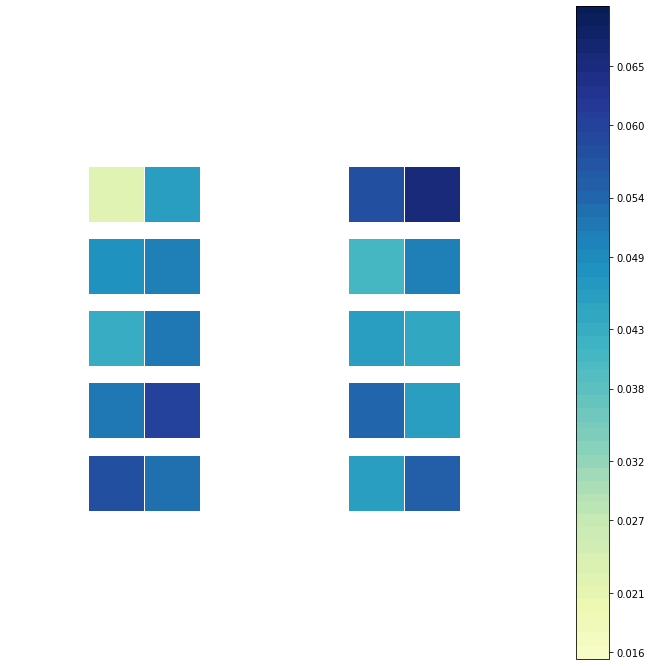

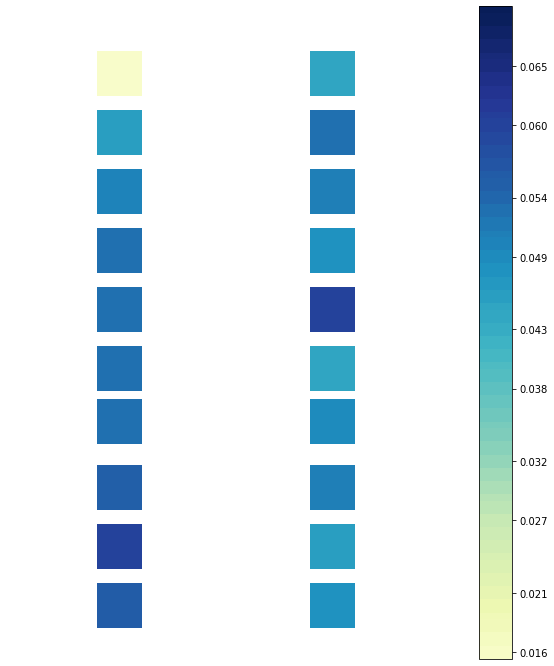

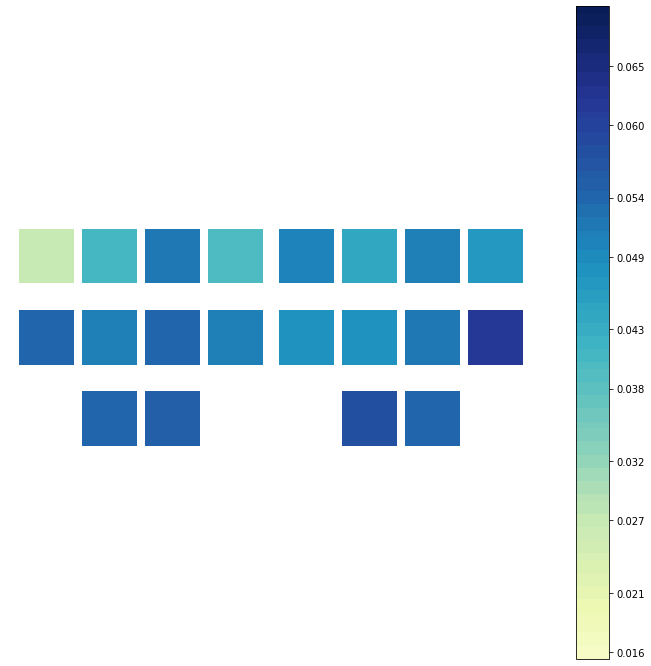

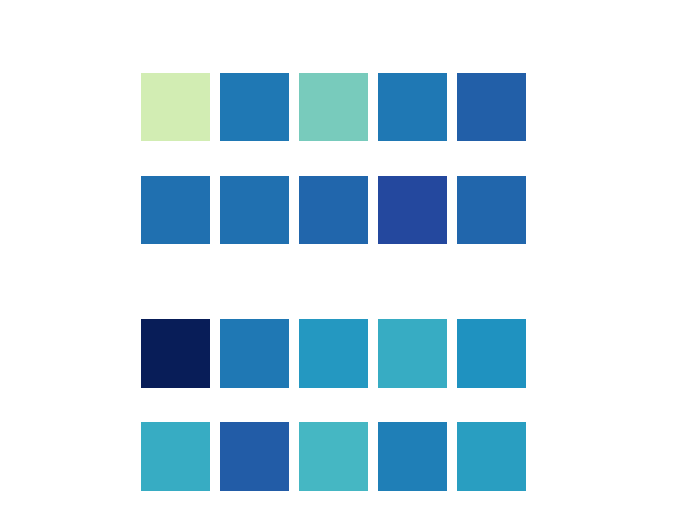

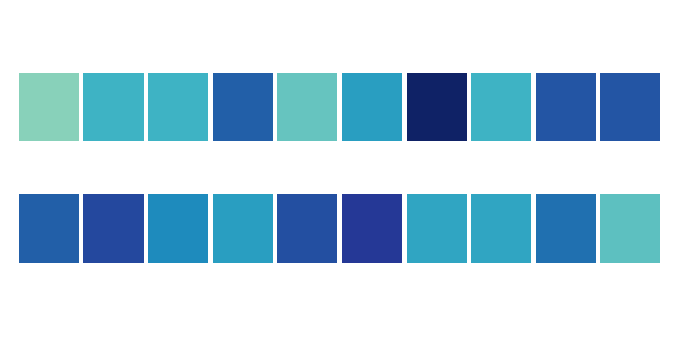

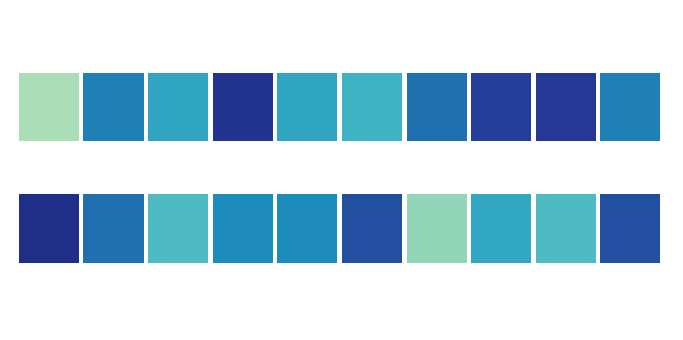

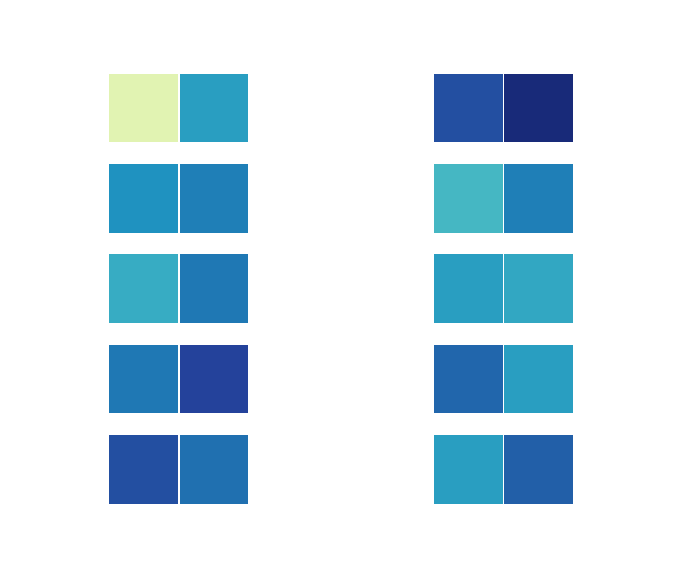

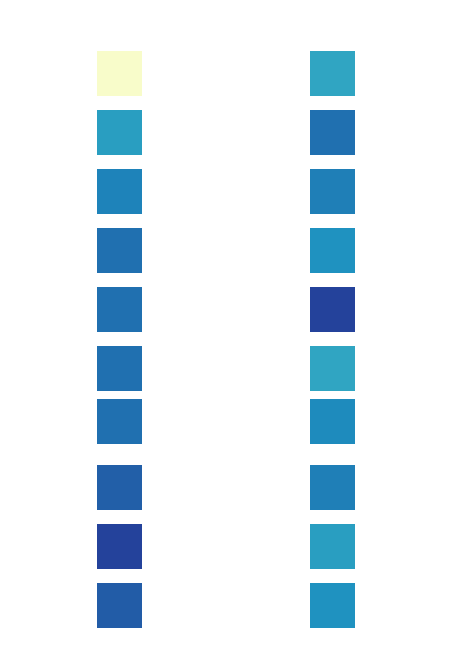

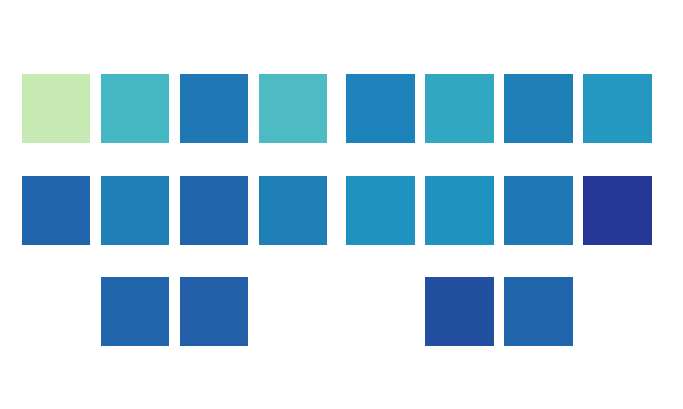

In [156]:
plot_not_within_ith_selection_new(d, 1, "rows", "not_within_1_selection", cb=True)
plot_not_within_ith_selection_new(d, 1, "row-single-scrollable", "not_within_1_selection", img_w=175, h = 950, cb=True)
plot_not_within_ith_selection_new(d, 1, "row-single", "not_within_1_selection", img_w=175, h = 950, cb = True)
plot_not_within_ith_selection_new(d, 1, "columns", "not_within_1_selection", h = 1600, cb=True)
plot_not_within_ith_selection_new(d, 1, "column-single", "not_within_1_selection", w=1950, h=2900, img_w = 200, img_h = 200, cb=True)
plot_not_within_ith_selection_new(d, 1, "max-columns", "not_within_1_selection", h = 1150, cb=True)
plot_not_within_ith_selection_new(d, 1, "rows", "not_within_1_selection", cb=False)
plot_not_within_ith_selection_new(d, 1, "row-single-scrollable", "not_within_1_selection", img_w=175, h = 950, cb=False)
plot_not_within_ith_selection_new(d, 1, "row-single", "not_within_1_selection", img_w=175, h = 950, cb = False)
plot_not_within_ith_selection_new(d, 1, "columns", "not_within_1_selection", h = 1600, cb=False)
plot_not_within_ith_selection_new(d, 1, "column-single", "not_within_1_selection", w=1950, h=2900, img_w = 200, img_h = 200, cb=False)
plot_not_within_ith_selection_new(d, 1, "max-columns", "not_within_1_selection", h = 1150, cb=False)

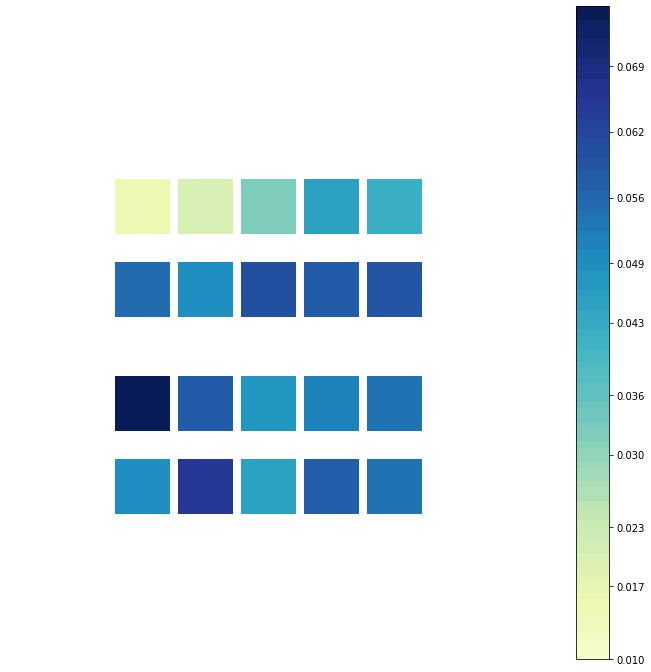

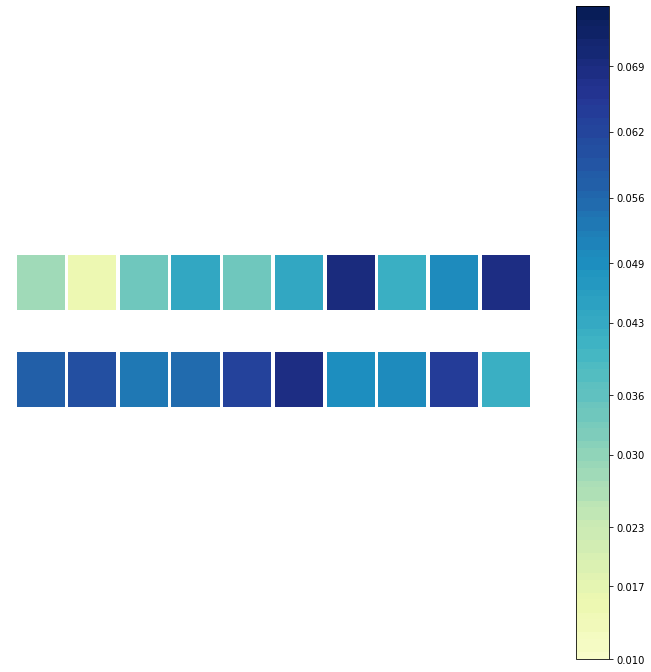

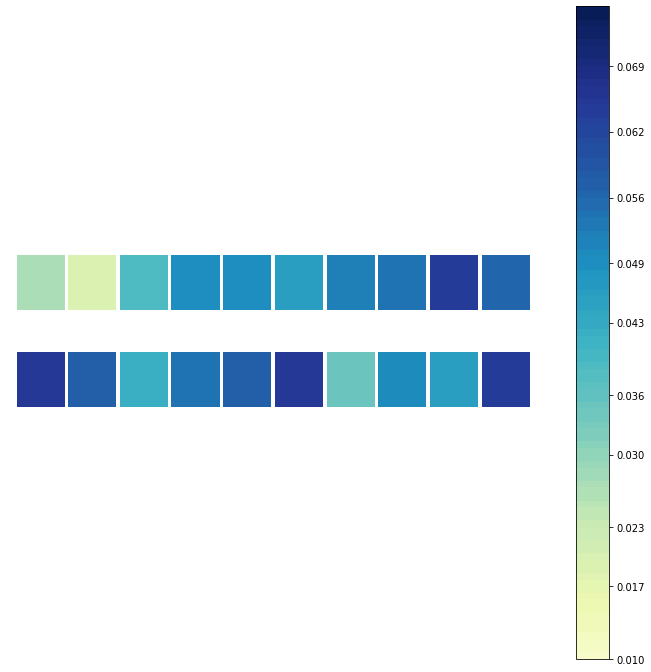

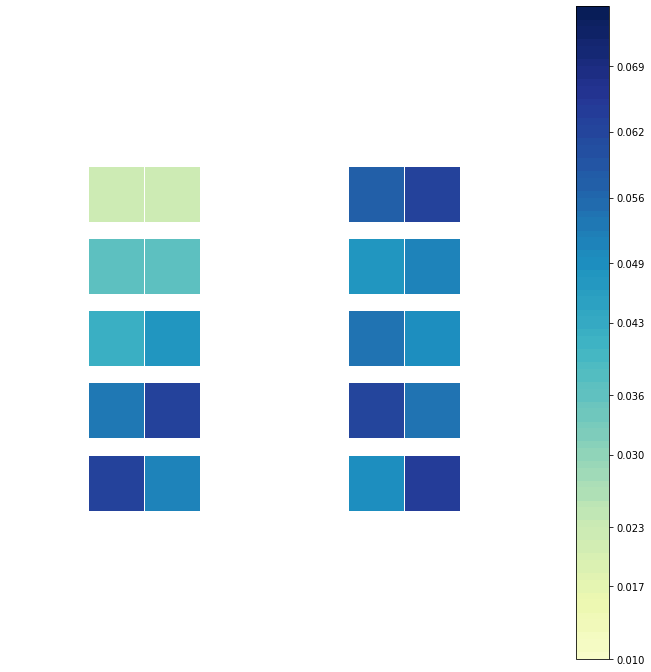

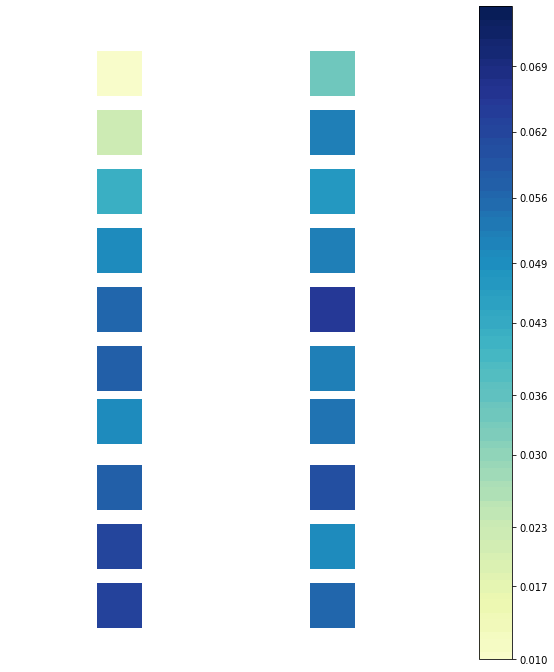

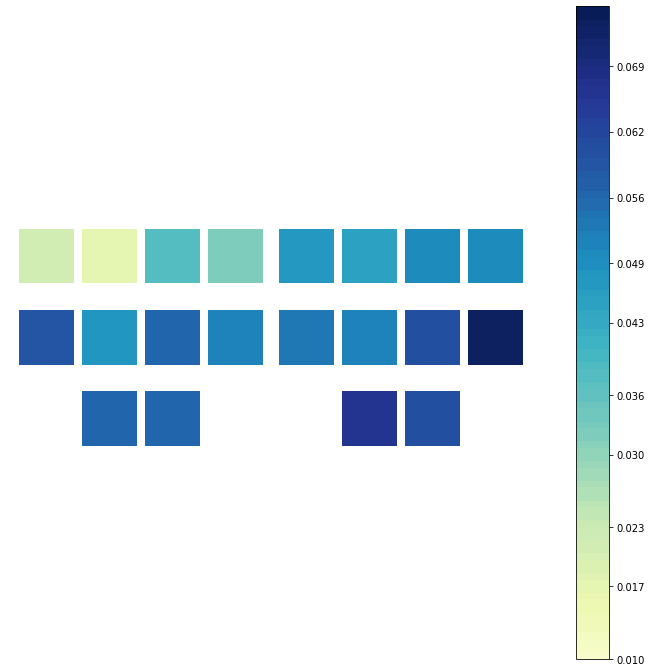

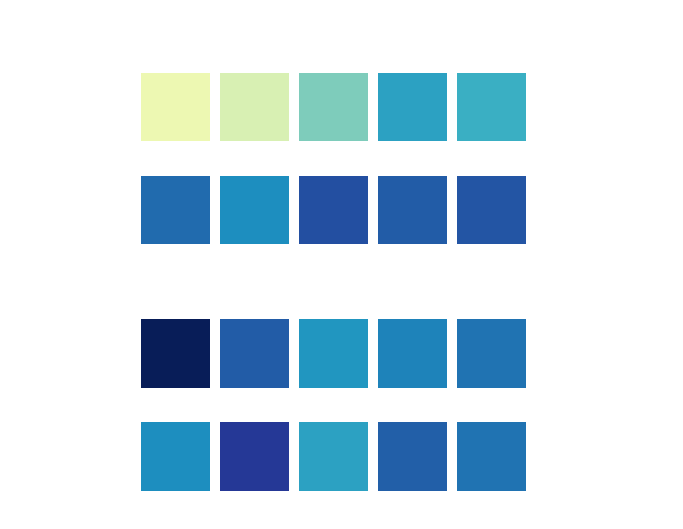

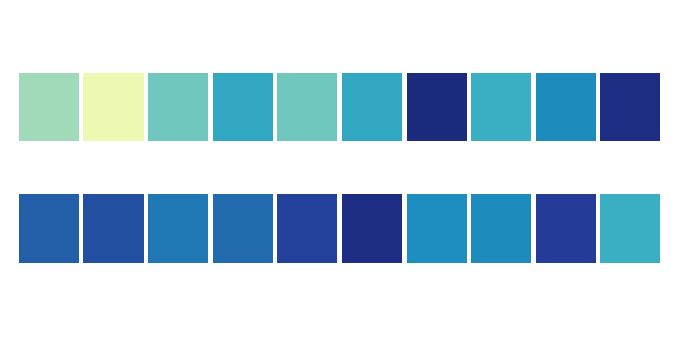

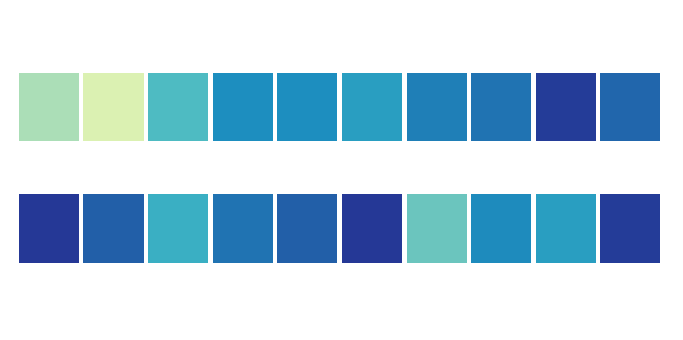

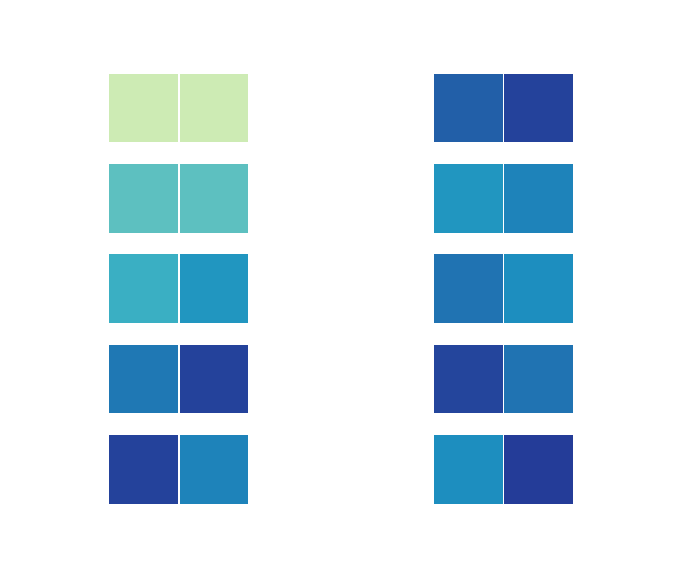

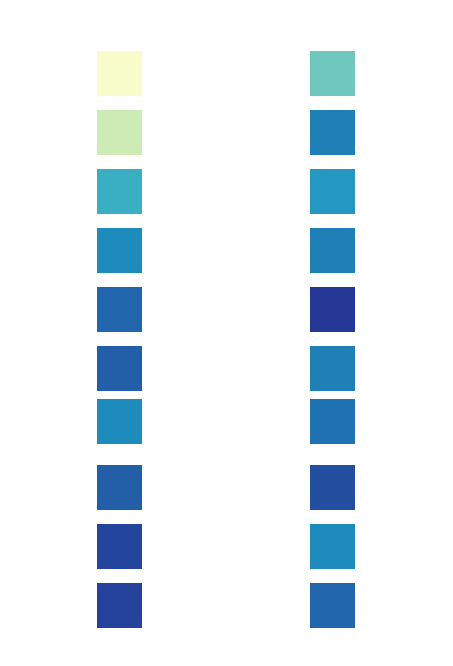

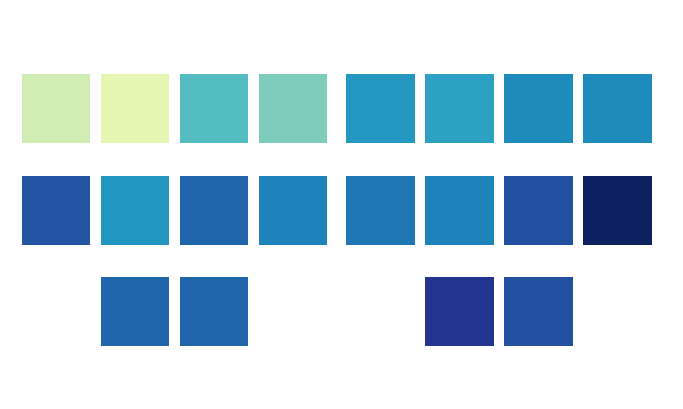

In [157]:
plot_not_within_ith_selection_new(d, 2, "rows", "not_within_2_selection", cb=True)
plot_not_within_ith_selection_new(d, 2, "row-single-scrollable", "not_within_2_selection", img_w=175, h = 950, cb=True)
plot_not_within_ith_selection_new(d, 2, "row-single", "not_within_2_selection", img_w=175, h = 950, cb = True)
plot_not_within_ith_selection_new(d, 2, "columns", "not_within_2_selection", h = 1600, cb=True)
plot_not_within_ith_selection_new(d, 2, "column-single", "not_within_2_selection", w=1950, h=2900, img_w = 200, img_h = 200, cb=True)
plot_not_within_ith_selection_new(d, 2, "max-columns", "not_within_2_selection", h = 1150, cb=True)
plot_not_within_ith_selection_new(d, 2, "rows", "not_within_2_selection", cb=False)
plot_not_within_ith_selection_new(d, 2, "row-single-scrollable", "not_within_2_selection", img_w=175, h = 950, cb=False)
plot_not_within_ith_selection_new(d, 2, "row-single", "not_within_2_selection", img_w=175, h = 950, cb = False)
plot_not_within_ith_selection_new(d, 2, "columns", "not_within_2_selection", h = 1600, cb=False)
plot_not_within_ith_selection_new(d, 2, "column-single", "not_within_2_selection", w=1950, h=2900, img_w = 200, img_h = 200, cb=False)
plot_not_within_ith_selection_new(d, 2, "max-columns", "not_within_2_selection", h = 1150, cb=False)

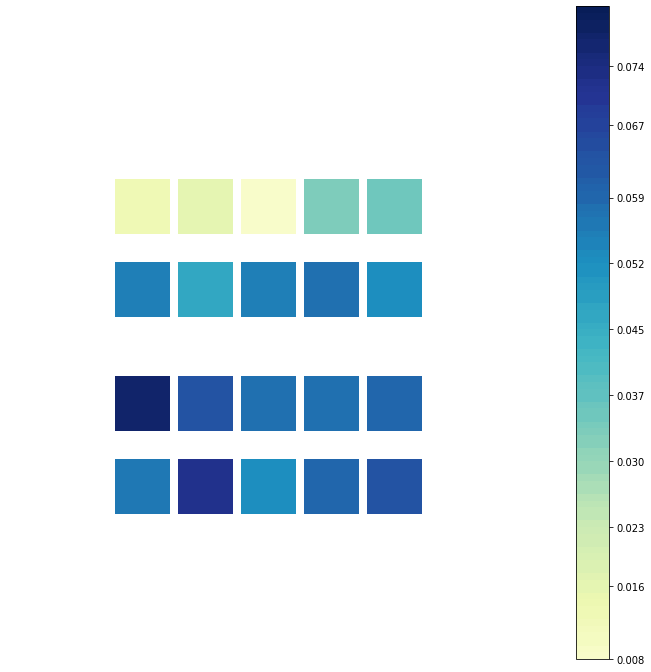

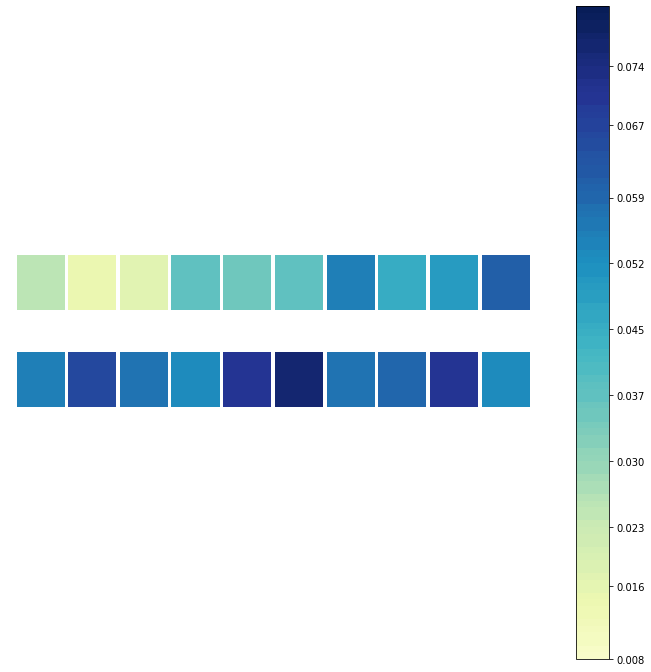

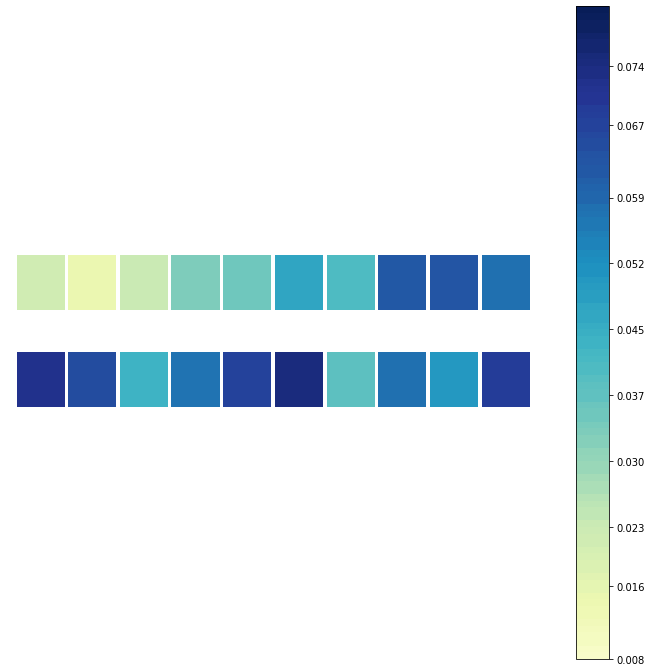

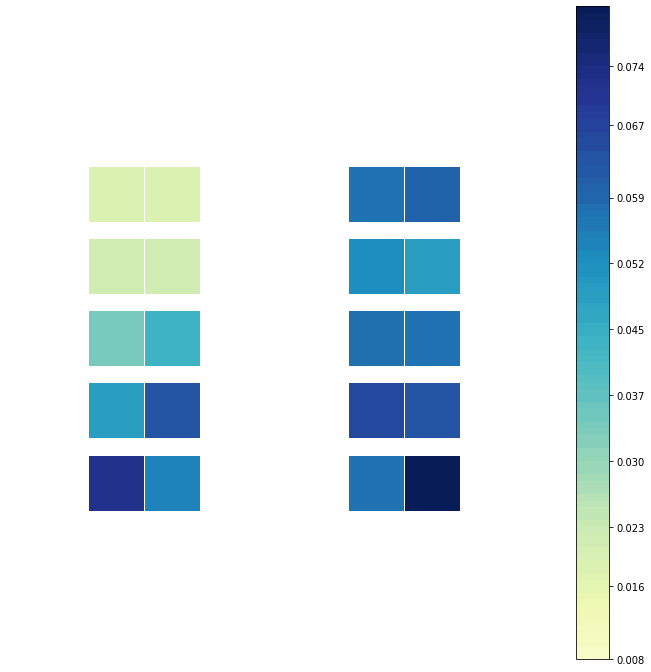

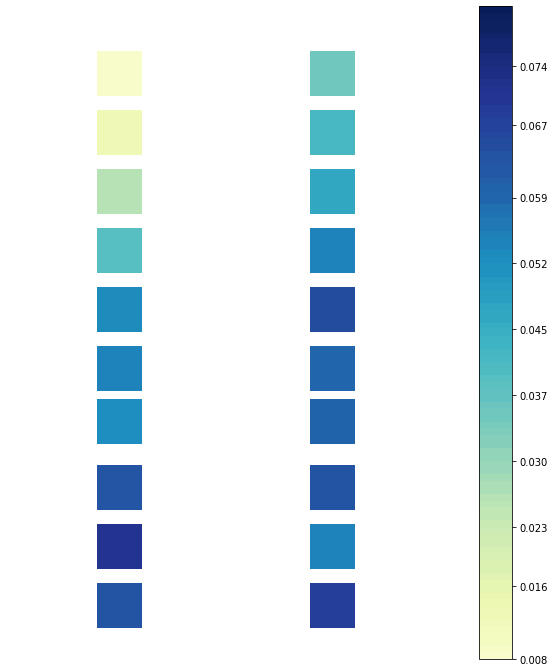

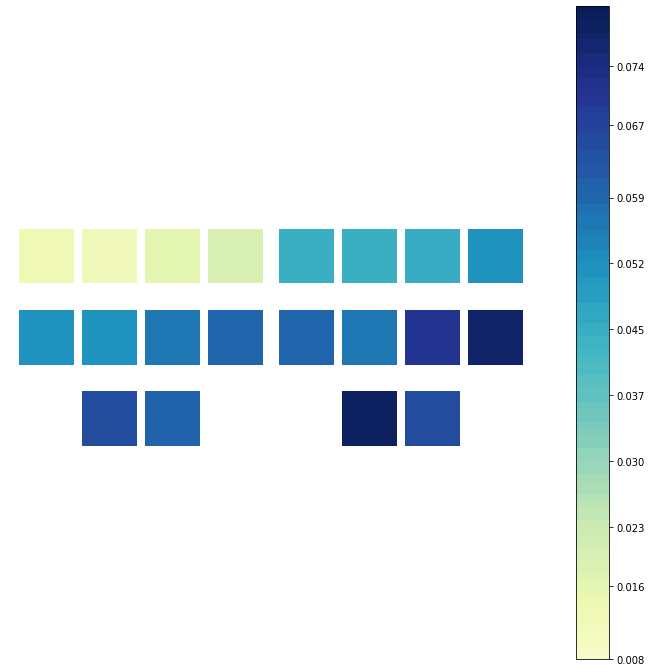

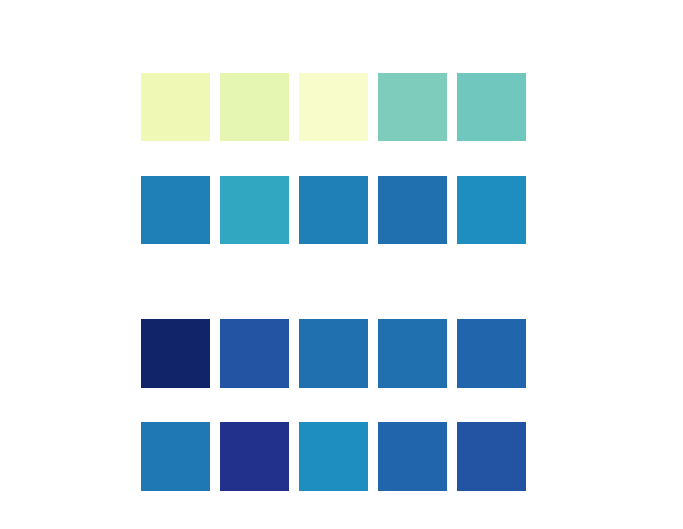

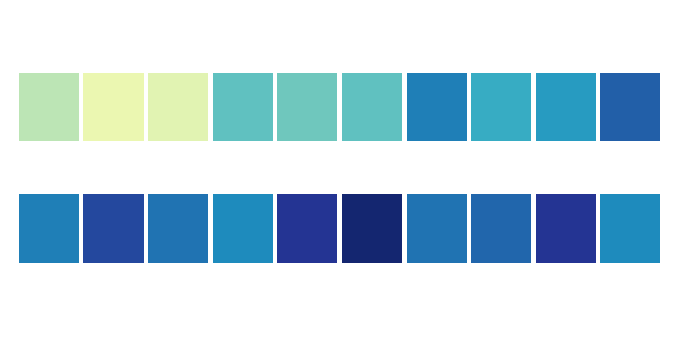

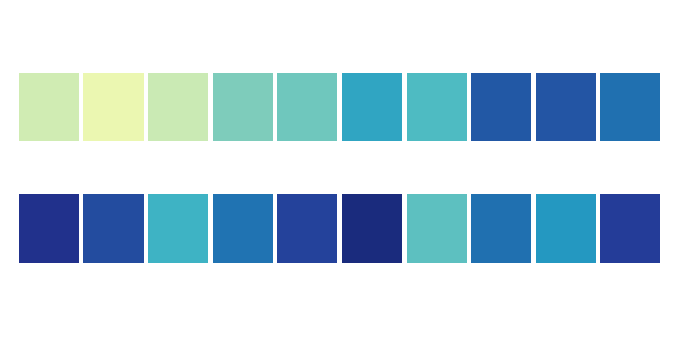

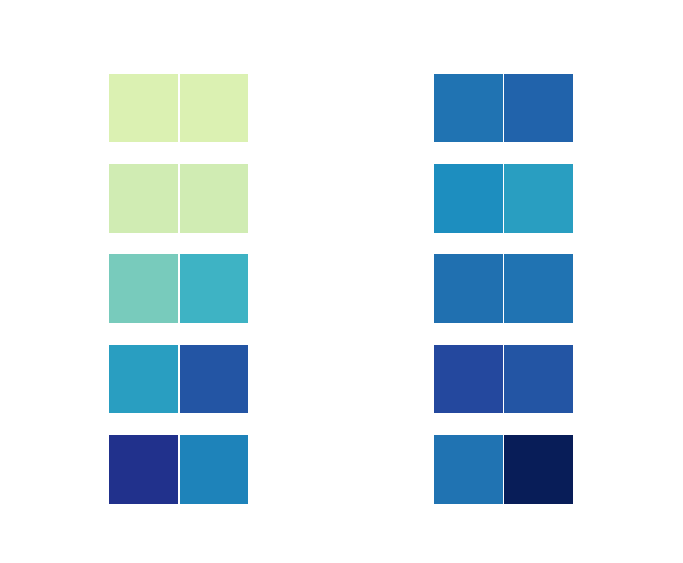

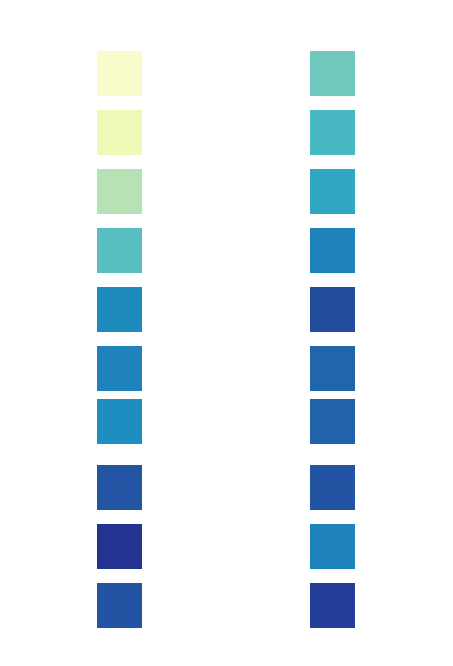

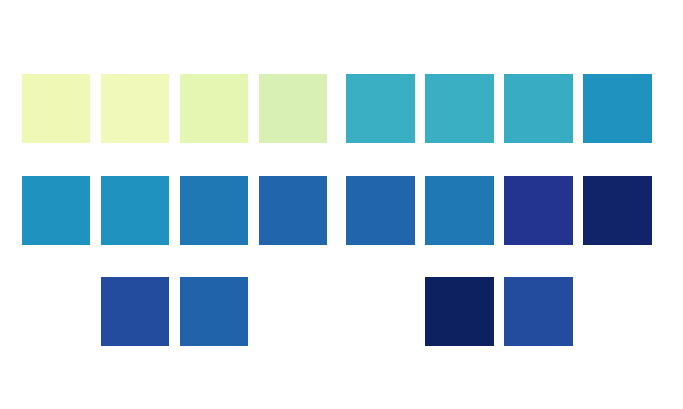

In [158]:
plot_not_within_ith_selection_new(d, 3, "rows", "not_within_3_selection", cb=True)
plot_not_within_ith_selection_new(d, 3, "row-single-scrollable", "not_within_3_selection", img_w=175, h = 950, cb=True)
plot_not_within_ith_selection_new(d, 3, "row-single", "not_within_3_selection", img_w=175, h = 950, cb = True)
plot_not_within_ith_selection_new(d, 3, "columns", "not_within_3_selection", h = 1600, cb=True)
plot_not_within_ith_selection_new(d, 3, "column-single", "not_within_3_selection", w=1950, h=2900, img_w = 200, img_h = 200, cb=True)
plot_not_within_ith_selection_new(d, 3, "max-columns", "not_within_3_selection", h = 1150, cb=True)
plot_not_within_ith_selection_new(d, 3, "rows", "not_within_3_selection", cb=False)
plot_not_within_ith_selection_new(d, 3, "row-single-scrollable", "not_within_3_selection", img_w=175, h = 950, cb=False)
plot_not_within_ith_selection_new(d, 3, "row-single", "not_within_3_selection", img_w=175, h = 950, cb = False)
plot_not_within_ith_selection_new(d, 3, "columns", "not_within_3_selection", h = 1600, cb=False)
plot_not_within_ith_selection_new(d, 3, "column-single", "not_within_3_selection", w=1950, h=2900, img_w = 200, img_h = 200, cb=False)
plot_not_within_ith_selection_new(d, 3, "max-columns", "not_within_3_selection", h = 1150, cb=False)